In [1]:
# Step 1.1: Setup and Configuration
import os
import sys
import json
import logging
import re
from pathlib import Path
import unicodedata
from datetime import datetime
from typing import Dict, List, Optional, Any, Union
import glob
import numpy as np
import torch
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
import weaviate
from weaviate.auth import AuthApiKey
from lxml import etree

# Setup logging to see detailed output
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("pubmed_pipeline")

# Configuration
config = {
    "output_dir": "./processed27",
    "embeddings_dir": "./processed_with_embeddings27",
    "chunk_size": 350,
    "chunk_overlap": 0.15,
    "min_chunk_size": 100,
    "max_chunk_size": 500,
    "respect_paragraphs": True,
    "weaviate_url": "http://149.165.151.58:8080",
    "weaviate_grpc_host": "149.165.151.58",
    "weaviate_grpc_port": 50051,
    "weaviate_api_key": "ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE=",
    "embedding_model": "pritamdeka/S-PubMedBERT-MS-MARCO",
    "test_limit": 20  # Process 20 files for testing
}

# Create output directories
os.makedirs(config["output_dir"], exist_ok=True)
os.makedirs(config["embeddings_dir"], exist_ok=True)

print(f"Configuration set. Will process {config['test_limit']} files.")
print(f"Output directories created: {config['output_dir']} and {config['embeddings_dir']}")

/Users/abhay/Desktop/college/uoa/year_2/info698-capstone/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration set. Will process 20 files.
Output directories created: ./processed27 and ./processed_with_embeddings27


In [15]:
!pip install weaviate-client

In [16]:
# Complete PubMedProcessor class with all methods included
class PubMedProcessor:
    def __init__(self, config: Dict = None):
        self.config = {
            "chunk_size": 350,
            "chunk_overlap": 0.15,
            "min_chunk_size": 100,
            "max_chunk_size": 500,
            "respect_paragraphs": True,
            "xml_namespaces": {"xlink": "http://www.w3.org/1999/xlink"},
        }
        if config:
            self.config.update(config)
        if "output_dir" in self.config:
            os.makedirs(self.config["output_dir"], exist_ok=True)

    def normalize_text(self, text: str) -> str:
        """Normalize text for consistent processing"""
        text = unicodedata.normalize('NFKC', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\[\s*\d+\s*\]', '', text)
        return text.strip()

    def parse_file(self, file_path: str) -> Optional[etree._Element]:
        """Parse an XML file and return the root element"""
        try:
            parser = etree.XMLParser(remove_blank_text=True, recover=True)
            tree = etree.parse(file_path, parser)
            return tree.getroot()
        except Exception as e:
            logger.error(f"Error parsing {file_path}: {e}")
            return None

    def _get_text_content(self, element) -> str:
        """Extract text content from an XML element"""
        if element is None:
            return ""

        try:
            if not element.getchildren():
                return element.text or ""
        except AttributeError:
            # For newer lxml versions
            if len(element) == 0:
                return element.text or ""

        return "".join(element.itertext()).strip()

    def extract_metadata(self, root: etree._Element) -> Dict:
        """Extract metadata from the XML root element"""
        metadata = {
            "processing_date": datetime.now().isoformat()
        }

        def safe_extract(xpath, is_list=False, attribute=None, root_elem=root):
            try:
                elements = root_elem.xpath(xpath, namespaces=self.config["xml_namespaces"])
                if not elements:
                    return [] if is_list else None

                if is_list:
                    if attribute:
                        return [e.get(attribute) for e in elements if e.get(attribute)]
                    return [self._get_text_content(e) for e in elements]

                if attribute:
                    return elements[0].get(attribute)
                return self._get_text_content(elements[0])
            except Exception as e:
                logger.warning(f"Error extracting {xpath}: {e}")
                return [] if is_list else None

        # Extract basic metadata
        metadata["pmid"] = safe_extract('.//article-id[@pub-id-type="pmid"]')
        metadata["pmc"] = safe_extract('.//article-id[@pub-id-type="pmc"]')
        metadata["doi"] = safe_extract('.//article-id[@pub-id-type="doi"]')
        metadata["title"] = safe_extract('.//article-title')
        metadata["article_type"] = safe_extract('.//article/@article-type', attribute='article-type')
        metadata["journal"] = safe_extract('.//journal-title')
        metadata["issn"] = safe_extract('.//issn')
        metadata["volume"] = safe_extract('.//volume')
        metadata["issue"] = safe_extract('.//issue')

        # Extract publication date
        pub_year = safe_extract('.//pub-date/year')
        pub_month = safe_extract('.//pub-date/month')
        pub_day = safe_extract('.//pub-date/day')

        if pub_year:
            metadata["publication_date"] = pub_year
            if pub_month:
                if pub_day:
                    metadata["publication_date"] = f"{pub_year}-{pub_month}-{pub_day}"
                else:
                    metadata["publication_date"] = f"{pub_year}-{pub_month}"

        # Extract authors
        authors = []
        author_elements = root.xpath('.//contrib[@contrib-type="author"]')
        for author_elem in author_elements:
            author = {}
            surname = safe_extract('.//surname', root_elem=author_elem)
            given_names = safe_extract('.//given-names', root_elem=author_elem)

            if surname or given_names:
                if surname and given_names:
                    author["name"] = f"{surname}, {given_names}"
                else:
                    author["name"] = surname or given_names

                try:
                    aff_id = safe_extract('.//xref[@ref-type="aff"]/@rid', root_elem=author_elem)
                    if aff_id:
                        affiliation = safe_extract(f'.//aff[@id="{aff_id}"]')
                        if affiliation:
                            author["affiliation"] = affiliation
                except:
                    # Skip affiliation on error
                    pass

                authors.append(author)

        if authors:
            metadata["authors"] = authors

        # Extract keywords
        keywords = safe_extract('.//kwd', is_list=True)
        if keywords:
            metadata["keywords"] = keywords

        # Extract section titles
        sections = []
        section_titles = safe_extract('.//sec/title', is_list=True)
        if section_titles:
            metadata["sections"] = section_titles

        return metadata

    def extract_text_sections(self, root: etree._Element) -> List[Dict[str, str]]:
        """Extract text sections from the XML root element"""
        sections = []

        # Extract abstract
        abstract_elements = root.xpath('.//abstract')
        for abstract_elem in abstract_elements:
            title = "Abstract"
            abstract_sections = abstract_elem.xpath('.//sec')

            if abstract_sections:
                for sec in abstract_sections:
                    sec_title = sec.xpath('./title')
                    sec_text = "".join(sec.itertext()).strip()
                    if sec_title:
                        section_title = f"Abstract - {sec_title[0].text}"
                    else:
                        section_title = "Abstract"

                    sections.append({
                        "title": section_title,
                        "text": sec_text
                    })
            else:
                abstract_text = "".join(abstract_elem.itertext()).strip()
                if abstract_text:
                    sections.append({
                        "title": title,
                        "text": abstract_text
                    })

        # Extract body sections
        body_elements = root.xpath('.//body')
        for body_elem in body_elements:
            body_sections = body_elem.xpath('./sec')

            if body_sections:
                for sec in body_sections:
                    sec_title_elem = sec.xpath('./title')
                    if sec_title_elem:
                        sec_title = sec_title_elem[0].text
                    else:
                        sec_title = "Body"

                    if sec_title_elem:
                        sec_text = "".join(sec.itertext()).replace(sec_title, "", 1).strip()
                    else:
                        sec_text = "".join(sec.itertext()).strip()

                    sections.append({
                        "title": sec_title,
                        "text": sec_text
                    })
            else:
                body_text = "".join(body_elem.itertext()).strip()
                if body_text:
                    sections.append({
                        "title": "Body",
                        "text": body_text
                    })

        return sections

    def estimate_tokens(self, text: str) -> int:
        """Estimate the number of tokens in the text"""
        return len(text.split())

    def chunk_text(self, sections: List[Dict[str, str]], metadata: Dict) -> List[Dict]:
        """Split sections into chunks based on token size"""
        chunks = []
        chunk_id = 0

        for section in sections:
            section_title = section["title"]
            section_text = self.normalize_text(section["text"])

            if not section_text:
                continue

            # Split by paragraphs if enabled
            if self.config["respect_paragraphs"]:
                paragraphs = re.split(r'\n\s*\n|\r\n\s*\r\n', section_text)
            else:
                paragraphs = [section_text]

            current_chunk = ""
            current_tokens = 0

            for paragraph in paragraphs:
                paragraph = paragraph.strip()
                if not paragraph:
                    continue

                paragraph_tokens = self.estimate_tokens(paragraph)

                if paragraph_tokens > self.config["max_chunk_size"]:
                    if current_tokens > 0:
                        chunk = {
                            "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                            "section": section_title,
                            "text": current_chunk,
                            "token_count": current_tokens
                        }
                        chunks.append(chunk)
                        chunk_id += 1
                        current_chunk = ""
                        current_tokens = 0

                    sentences = re.split(r'(?<=[.!?])\s+', paragraph)
                    temp_chunk = ""
                    temp_tokens = 0

                    for sentence in sentences:
                        sentence_tokens = self.estimate_tokens(sentence)

                        if temp_tokens + sentence_tokens <= self.config["chunk_size"]:
                            if temp_chunk:
                                temp_chunk += " " + sentence
                            else:
                                temp_chunk = sentence
                            temp_tokens += sentence_tokens
                        else:
                            if temp_chunk:
                                chunk = {
                                    "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                                    "section": section_title,
                                    "text": temp_chunk,
                                    "token_count": temp_tokens
                                }
                                chunks.append(chunk)
                                chunk_id += 1

                            temp_chunk = sentence
                            temp_tokens = sentence_tokens

                    if temp_chunk:
                        chunk = {
                            "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                            "section": section_title,
                            "text": temp_chunk,
                            "token_count": temp_tokens
                        }
                        chunks.append(chunk)
                        chunk_id += 1

                elif current_tokens + paragraph_tokens <= self.config["chunk_size"]:
                    if current_chunk:
                        current_chunk += " " + paragraph
                    else:
                        current_chunk = paragraph
                    current_tokens += paragraph_tokens
                else:
                    chunk = {
                        "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                        "section": section_title,
                        "text": current_chunk,
                        "token_count": current_tokens
                    }
                    chunks.append(chunk)
                    chunk_id += 1

                    current_chunk = paragraph
                    current_tokens = paragraph_tokens

            if current_chunk and current_tokens >= self.config["min_chunk_size"]:
                chunk = {
                    "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                    "section": section_title,
                    "text": current_chunk,
                    "token_count": current_tokens
                }
                chunks.append(chunk)
                chunk_id += 1

        # Add metadata to each chunk
        for chunk in chunks:
            chunk["metadata"] = {
                "pmid": metadata.get("pmid"),
                "title": metadata.get("title"),
                "journal": metadata.get("journal"),
                "publication_date": metadata.get("publication_date"),
                "doi": metadata.get("doi")
            }
            # Remove None values
            chunk["metadata"] = {k: v for k, v in chunk["metadata"].items() if v is not None}

        return chunks

    def process_file(self, file_path: str) -> Optional[Dict]:
        """Process a single XML file"""
        logger.info(f"Processing {file_path}")

        # Parse the file
        root = self.parse_file(file_path)
        if root is None:
            logger.error(f"Failed to parse {file_path}")
            return None

        # Extract metadata
        metadata = self.extract_metadata(root)
        if not metadata.get("pmid"):
            metadata["pmid"] = Path(file_path).stem

        # Extract text sections
        sections = self.extract_text_sections(root)

        # Chunk text
        chunks = self.chunk_text(sections, metadata)

        # Create document
        document = {
            "document_id": metadata.get("pmid", Path(file_path).stem),
            "file_path": str(file_path),
            "metadata": metadata,
            "chunks": chunks,
            "chunk_count": len(chunks)
        }

        logger.info(f"Extracted {len(sections)} sections and {len(chunks)} chunks")
        return document

    def save_document(self, document: Dict, output_format: str = "json") -> None:
        """Save the processed document"""
        output_dir = self.config.get("output_dir", ".")
        document_id = document["document_id"]

        if output_format == "json":
            output_file = os.path.join(output_dir, f"{document_id}.json")
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(document, f, ensure_ascii=False, indent=2)
            logger.info(f"Saved to {output_file}")
        else:
            logger.error(f"Unsupported output format: {output_format}")

    def process_directory(self, directory_path: str, output_format: str = "json", file_limit: int = None) -> int:
        """Process all XML files in a directory"""
        directory = Path(directory_path)
        if not directory.exists() or not directory.is_dir():
            logger.error(f"Directory not found: {directory_path}")
            return 0

        # Find all XML files
        all_files = list(directory.glob("**/*.xml")) + list(directory.glob("**/*.nxml"))
        logger.info(f"Found {len(all_files)} XML files in {directory_path}")

        # Limit the number of files if specified
        if file_limit and file_limit > 0:
            files_to_process = all_files[:file_limit]
            logger.info(f"Processing {len(files_to_process)} out of {len(all_files)} files")
        else:
            files_to_process = all_files

        # Process each file
        processed_count = 0
        failed_count = 0

        for file_path in tqdm(files_to_process, desc="Processing XML files"):
            try:
                document = self.process_file(str(file_path))
                if document:
                    self.save_document(document, output_format)
                    processed_count += 1
                else:
                    failed_count += 1
            except Exception as e:
                logger.error(f"Error processing {file_path}: {e}", exc_info=True)
                failed_count += 1

        logger.info(f"Processing complete. Successfully processed: {processed_count}, Failed: {failed_count}")
        return processed_count

# Create an instance of the processor
processor = PubMedProcessor(config)
print("Complete PubMedProcessor class initialized.")

Complete PubMedProcessor class initialized.


In [17]:
# Complete PubMedProcessor class with all methods included
class PubMedProcessor:
    def __init__(self, config: Dict = None):
        self.config = {
            "chunk_size": 350,
            "chunk_overlap": 0.15,
            "min_chunk_size": 100,
            "max_chunk_size": 500,
            "respect_paragraphs": True,
            "xml_namespaces": {"xlink": "http://www.w3.org/1999/xlink"},
        }
        if config:
            self.config.update(config)
        if "output_dir" in self.config:
            os.makedirs(self.config["output_dir"], exist_ok=True)

    def normalize_text(self, text: str) -> str:
        """Normalize text for consistent processing"""
        text = unicodedata.normalize('NFKC', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\[\s*\d+\s*\]', '', text)
        return text.strip()

    def parse_file(self, file_path: str) -> Optional[etree._Element]:
        """Parse an XML file and return the root element"""
        try:
            parser = etree.XMLParser(remove_blank_text=True, recover=True)
            tree = etree.parse(file_path, parser)
            return tree.getroot()
        except Exception as e:
            logger.error(f"Error parsing {file_path}: {e}")
            return None

    def _get_text_content(self, element) -> str:
        """Extract text content from an XML element"""
        if element is None:
            return ""

        try:
            if not element.getchildren():
                return element.text or ""
        except AttributeError:
            # For newer lxml versions
            if len(element) == 0:
                return element.text or ""

        return "".join(element.itertext()).strip()

    def extract_metadata(self, root: etree._Element) -> Dict:
        """Extract metadata from the XML root element"""
        metadata = {
            "processing_date": datetime.now().isoformat()
        }

        def safe_extract(xpath, is_list=False, attribute=None, root_elem=root):
            try:
                elements = root_elem.xpath(xpath, namespaces=self.config["xml_namespaces"])
                if not elements:
                    return [] if is_list else None

                if is_list:
                    if attribute:
                        return [e.get(attribute) for e in elements if e.get(attribute)]
                    return [self._get_text_content(e) for e in elements]

                if attribute:
                    return elements[0].get(attribute)
                return self._get_text_content(elements[0])
            except Exception as e:
                logger.warning(f"Error extracting {xpath}: {e}")
                return [] if is_list else None

        # Extract basic metadata
        metadata["pmid"] = safe_extract('.//article-id[@pub-id-type="pmid"]')
        metadata["pmc"] = safe_extract('.//article-id[@pub-id-type="pmc"]')
        metadata["doi"] = safe_extract('.//article-id[@pub-id-type="doi"]')
        metadata["title"] = safe_extract('.//article-title')
        metadata["article_type"] = safe_extract('.//article/@article-type', attribute='article-type')
        metadata["journal"] = safe_extract('.//journal-title')
        metadata["issn"] = safe_extract('.//issn')
        metadata["volume"] = safe_extract('.//volume')
        metadata["issue"] = safe_extract('.//issue')

        # Extract publication date
        pub_year = safe_extract('.//pub-date/year')
        pub_month = safe_extract('.//pub-date/month')
        pub_day = safe_extract('.//pub-date/day')

        if pub_year:
            metadata["publication_date"] = pub_year
            if pub_month:
                if pub_day:
                    metadata["publication_date"] = f"{pub_year}-{pub_month}-{pub_day}"
                else:
                    metadata["publication_date"] = f"{pub_year}-{pub_month}"

        # Extract authors
        authors = []
        author_elements = root.xpath('.//contrib[@contrib-type="author"]')
        for author_elem in author_elements:
            author = {}
            surname = safe_extract('.//surname', root_elem=author_elem)
            given_names = safe_extract('.//given-names', root_elem=author_elem)

            if surname or given_names:
                if surname and given_names:
                    author["name"] = f"{surname}, {given_names}"
                else:
                    author["name"] = surname or given_names

                try:
                    aff_id = safe_extract('.//xref[@ref-type="aff"]/@rid', root_elem=author_elem)
                    if aff_id:
                        affiliation = safe_extract(f'.//aff[@id="{aff_id}"]')
                        if affiliation:
                            author["affiliation"] = affiliation
                except:
                    # Skip affiliation on error
                    pass

                authors.append(author)

        if authors:
            metadata["authors"] = authors

        # Extract keywords
        keywords = safe_extract('.//kwd', is_list=True)
        if keywords:
            metadata["keywords"] = keywords

        # Extract section titles
        sections = []
        section_titles = safe_extract('.//sec/title', is_list=True)
        if section_titles:
            metadata["sections"] = section_titles

        return metadata

    def extract_text_sections(self, root: etree._Element) -> List[Dict[str, str]]:
        """Extract text sections from the XML root element"""
        sections = []

        # Extract abstract
        abstract_elements = root.xpath('.//abstract')
        for abstract_elem in abstract_elements:
            title = "Abstract"
            abstract_sections = abstract_elem.xpath('.//sec')

            if abstract_sections:
                for sec in abstract_sections:
                    sec_title = sec.xpath('./title')
                    sec_text = "".join(sec.itertext()).strip()
                    if sec_title:
                        section_title = f"Abstract - {sec_title[0].text}"
                    else:
                        section_title = "Abstract"

                    sections.append({
                        "title": section_title,
                        "text": sec_text
                    })
            else:
                abstract_text = "".join(abstract_elem.itertext()).strip()
                if abstract_text:
                    sections.append({
                        "title": title,
                        "text": abstract_text
                    })

        # Extract body sections
        body_elements = root.xpath('.//body')
        for body_elem in body_elements:
            body_sections = body_elem.xpath('./sec')

            if body_sections:
                for sec in body_sections:
                    sec_title_elem = sec.xpath('./title')
                    if sec_title_elem:
                        sec_title = sec_title_elem[0].text
                    else:
                        sec_title = "Body"

                    if sec_title_elem:
                        sec_text = "".join(sec.itertext()).replace(sec_title, "", 1).strip()
                    else:
                        sec_text = "".join(sec.itertext()).strip()

                    sections.append({
                        "title": sec_title,
                        "text": sec_text
                    })
            else:
                body_text = "".join(body_elem.itertext()).strip()
                if body_text:
                    sections.append({
                        "title": "Body",
                        "text": body_text
                    })

        return sections

    def estimate_tokens(self, text: str) -> int:
        """Estimate the number of tokens in the text"""
        return len(text.split())

    def chunk_text(self, sections: List[Dict[str, str]], metadata: Dict) -> List[Dict]:
        """Split sections into chunks based on token size"""
        chunks = []
        chunk_id = 0

        for section in sections:
            section_title = section["title"]
            section_text = self.normalize_text(section["text"])

            if not section_text:
                continue

            # Split by paragraphs if enabled
            if self.config["respect_paragraphs"]:
                paragraphs = re.split(r'\n\s*\n|\r\n\s*\r\n', section_text)
            else:
                paragraphs = [section_text]

            current_chunk = ""
            current_tokens = 0

            for paragraph in paragraphs:
                paragraph = paragraph.strip()
                if not paragraph:
                    continue

                paragraph_tokens = self.estimate_tokens(paragraph)

                if paragraph_tokens > self.config["max_chunk_size"]:
                    if current_tokens > 0:
                        chunk = {
                            "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                            "section": section_title,
                            "text": current_chunk,
                            "token_count": current_tokens
                        }
                        chunks.append(chunk)
                        chunk_id += 1
                        current_chunk = ""
                        current_tokens = 0

                    sentences = re.split(r'(?<=[.!?])\s+', paragraph)
                    temp_chunk = ""
                    temp_tokens = 0

                    for sentence in sentences:
                        sentence_tokens = self.estimate_tokens(sentence)

                        if temp_tokens + sentence_tokens <= self.config["chunk_size"]:
                            if temp_chunk:
                                temp_chunk += " " + sentence
                            else:
                                temp_chunk = sentence
                            temp_tokens += sentence_tokens
                        else:
                            if temp_chunk:
                                chunk = {
                                    "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                                    "section": section_title,
                                    "text": temp_chunk,
                                    "token_count": temp_tokens
                                }
                                chunks.append(chunk)
                                chunk_id += 1

                            temp_chunk = sentence
                            temp_tokens = sentence_tokens

                    if temp_chunk:
                        chunk = {
                            "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                            "section": section_title,
                            "text": temp_chunk,
                            "token_count": temp_tokens
                        }
                        chunks.append(chunk)
                        chunk_id += 1

                elif current_tokens + paragraph_tokens <= self.config["chunk_size"]:
                    if current_chunk:
                        current_chunk += " " + paragraph
                    else:
                        current_chunk = paragraph
                    current_tokens += paragraph_tokens
                else:
                    chunk = {
                        "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                        "section": section_title,
                        "text": current_chunk,
                        "token_count": current_tokens
                    }
                    chunks.append(chunk)
                    chunk_id += 1

                    current_chunk = paragraph
                    current_tokens = paragraph_tokens

            if current_chunk and current_tokens >= self.config["min_chunk_size"]:
                chunk = {
                    "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                    "section": section_title,
                    "text": current_chunk,
                    "token_count": current_tokens
                }
                chunks.append(chunk)
                chunk_id += 1

        # Add metadata to each chunk
        for chunk in chunks:
            chunk["metadata"] = {
                "pmid": metadata.get("pmid"),
                "title": metadata.get("title"),
                "journal": metadata.get("journal"),
                "publication_date": metadata.get("publication_date"),
                "doi": metadata.get("doi")
            }
            # Remove None values
            chunk["metadata"] = {k: v for k, v in chunk["metadata"].items() if v is not None}

        return chunks

    def process_file(self, file_path: str) -> Optional[Dict]:
        """Process a single XML file"""
        logger.info(f"Processing {file_path}")

        # Parse the file
        root = self.parse_file(file_path)
        if root is None:
            logger.error(f"Failed to parse {file_path}")
            return None

        # Extract metadata
        metadata = self.extract_metadata(root)
        if not metadata.get("pmid"):
            metadata["pmid"] = Path(file_path).stem

        # Extract text sections
        sections = self.extract_text_sections(root)

        # Chunk text
        chunks = self.chunk_text(sections, metadata)

        # Create document
        document = {
            "document_id": metadata.get("pmid", Path(file_path).stem),
            "file_path": str(file_path),
            "metadata": metadata,
            "chunks": chunks,
            "chunk_count": len(chunks)
        }

        logger.info(f"Extracted {len(sections)} sections and {len(chunks)} chunks")
        return document

    def save_document(self, document: Dict, output_format: str = "json") -> None:
        """Save the processed document"""
        output_dir = self.config.get("output_dir", ".")
        document_id = document["document_id"]

        if output_format == "json":
            output_file = os.path.join(output_dir, f"{document_id}.json")
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(document, f, ensure_ascii=False, indent=2)
            logger.info(f"Saved to {output_file}")
        else:
            logger.error(f"Unsupported output format: {output_format}")

    def process_directory(self, directory_path: str, output_format: str = "json", file_limit: int = None) -> int:
        """Process all XML files in a directory"""
        directory = Path(directory_path)
        if not directory.exists() or not directory.is_dir():
            logger.error(f"Directory not found: {directory_path}")
            return 0

        # Find all XML files
        all_files = list(directory.glob("**/*.xml")) + list(directory.glob("**/*.nxml"))
        logger.info(f"Found {len(all_files)} XML files in {directory_path}")

        # Limit the number of files if specified
        if file_limit and file_limit > 0:
            files_to_process = all_files[:file_limit]
            logger.info(f"Processing {len(files_to_process)} out of {len(all_files)} files")
        else:
            files_to_process = all_files

        # Process each file
        processed_count = 0
        failed_count = 0

        for file_path in tqdm(files_to_process, desc="Processing XML files"):
            try:
                document = self.process_file(str(file_path))
                if document:
                    self.save_document(document, output_format)
                    processed_count += 1
                else:
                    failed_count += 1
            except Exception as e:
                logger.error(f"Error processing {file_path}: {e}", exc_info=True)
                failed_count += 1

        logger.info(f"Processing complete. Successfully processed: {processed_count}, Failed: {failed_count}")
        return processed_count

# Create an instance of the processor
processor = PubMedProcessor(config)
print("Complete PubMedProcessor class initialized.")

Complete PubMedProcessor class initialized.


In [18]:
# Step 1.4: Implement metadata extraction
def extract_metadata(self, root: etree._Element) -> Dict:
    """Extract metadata from the XML root element"""
    metadata = {
        "processing_date": datetime.now().isoformat()
    }

    def safe_extract(xpath, is_list=False, attribute=None, root_elem=root):
        try:
            elements = root_elem.xpath(xpath, namespaces=self.config["xml_namespaces"])
            if not elements:
                return [] if is_list else None

            if is_list:
                if attribute:
                    return [e.get(attribute) for e in elements if e.get(attribute)]
                return [self._get_text_content(e) for e in elements]

            if attribute:
                return elements[0].get(attribute)
            return self._get_text_content(elements[0])
        except Exception as e:
            logger.warning(f"Error extracting {xpath}: {e}")
            return [] if is_list else None

    # Extract basic metadata
    metadata["pmid"] = safe_extract('.//article-id[@pub-id-type="pmid"]')
    metadata["doi"] = safe_extract('.//article-id[@pub-id-type="doi"]')
    metadata["title"] = safe_extract('.//article-title')
    metadata["journal"] = safe_extract('.//journal-title')

    # Extract authors
    authors = []
    author_elements = root.xpath('.//contrib[@contrib-type="author"]')
    for author_elem in author_elements:
        surname = safe_extract('.//surname', root_elem=author_elem)
        given_names = safe_extract('.//given-names', root_elem=author_elem)
        if surname or given_names:
            name = f"{surname}, {given_names}" if surname and given_names else (surname or given_names)
            authors.append({"name": name})

    if authors:
        metadata["authors"] = authors

    return metadata

# Add this method to the PubMedProcessor class
PubMedProcessor.extract_metadata = extract_metadata

print("Metadata extraction method added.")

Metadata extraction method added.


In [19]:
# Step 1.5: Implement text extraction and chunking
def extract_text_sections(self, root: etree._Element) -> List[Dict[str, str]]:
    """Extract text sections from the XML root element"""
    sections = []

    # Extract abstract
    abstract_elements = root.xpath('.//abstract')
    for abstract_elem in abstract_elements:
        abstract_text = "".join(abstract_elem.itertext()).strip()
        if abstract_text:
            sections.append({
                "title": "Abstract",
                "text": abstract_text
            })

    # Extract body sections
    body_elements = root.xpath('.//body')
    for body_elem in body_elements:
        body_sections = body_elem.xpath('./sec')
        if body_sections:
            for sec in body_sections:
                sec_title_elem = sec.xpath('./title')
                sec_title = self._get_text_content(sec_title_elem[0]) if sec_title_elem else "Body"
                sec_text = "".join(sec.itertext()).strip()
                if sec_title in sec_text:
                    sec_text = sec_text.replace(sec_title, "", 1).strip()
                sections.append({
                    "title": sec_title,
                    "text": sec_text
                })
        else:
            # If no sections, take the whole body
            body_text = "".join(body_elem.itertext()).strip()
            if body_text:
                sections.append({
                    "title": "Body",
                    "text": body_text
                })

    return sections

def estimate_tokens(self, text: str) -> int:
    """Estimate the number of tokens in the text"""
    return len(text.split())

def chunk_text(self, sections: List[Dict[str, str]], metadata: Dict) -> List[Dict]:
    """Split sections into chunks based on token size"""
    chunks = []
    chunk_id = 0

    for section in sections:
        section_title = section["title"]
        section_text = self.normalize_text(section["text"])

        if not section_text:
            continue

        # Split by paragraphs if enabled
        if self.config["respect_paragraphs"]:
            paragraphs = re.split(r'\n\s*\n|\r\n\s*\r\n', section_text)
        else:
            paragraphs = [section_text]

        # Process each paragraph
        for paragraph in paragraphs:
            paragraph = paragraph.strip()
            if not paragraph:
                continue

            # If paragraph is too long, break it into sentences
            paragraph_tokens = self.estimate_tokens(paragraph)
            if paragraph_tokens > self.config["max_chunk_size"]:
                sentences = re.split(r'(?<=[.!?])\s+', paragraph)
                current_chunk = ""
                current_tokens = 0

                for sentence in sentences:
                    sentence_tokens = self.estimate_tokens(sentence)
                    if current_tokens + sentence_tokens <= self.config["chunk_size"]:
                        if current_chunk:
                            current_chunk += " " + sentence
                        else:
                            current_chunk = sentence
                        current_tokens += sentence_tokens
                    else:
                        if current_chunk:
                            chunks.append({
                                "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                                "section": section_title,
                                "text": current_chunk,
                                "token_count": current_tokens
                            })
                            chunk_id += 1
                        current_chunk = sentence
                        current_tokens = sentence_tokens

                if current_chunk and current_tokens >= self.config["min_chunk_size"]:
                    chunks.append({
                        "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                        "section": section_title,
                        "text": current_chunk,
                        "token_count": current_tokens
                    })
                    chunk_id += 1
            else:
                # If paragraph fits in a chunk, add it directly
                chunks.append({
                    "chunk_id": f"{metadata.get('pmid', 'unknown')}-{chunk_id}",
                    "section": section_title,
                    "text": paragraph,
                    "token_count": paragraph_tokens
                })
                chunk_id += 1

    # Add metadata to each chunk
    for chunk in chunks:
        chunk["metadata"] = {
            "pmid": metadata.get("pmid"),
            "title": metadata.get("title"),
            "journal": metadata.get("journal")
        }
        # Remove None values
        chunk["metadata"] = {k: v for k, v in chunk["metadata"].items() if v is not None}

    return chunks

# Add these methods to the PubMedProcessor class
PubMedProcessor.extract_text_sections = extract_text_sections
PubMedProcessor.estimate_tokens = estimate_tokens
PubMedProcessor.chunk_text = chunk_text

print("Text extraction and chunking methods added.")

Text extraction and chunking methods added.


In [20]:
# Step 1.6: Implement file processing methods
def process_file(self, file_path: str) -> Optional[Dict]:
    """Process a single XML file"""
    logger.info(f"Processing {file_path}")

    # Parse the file
    root = self.parse_file(file_path)
    if root is None:
        logger.error(f"Failed to parse {file_path}")
        return None

    # Extract metadata
    metadata = self.extract_metadata(root)
    if not metadata.get("pmid"):
        metadata["pmid"] = Path(file_path).stem

    # Extract text sections
    sections = self.extract_text_sections(root)

    # Chunk text
    chunks = self.chunk_text(sections, metadata)

    # Create document
    document = {
        "document_id": metadata.get("pmid", Path(file_path).stem),
        "file_path": str(file_path),
        "metadata": metadata,
        "chunks": chunks,
        "chunk_count": len(chunks)
    }

    # Log some stats
    logger.info(f"Extracted {len(sections)} sections and {len(chunks)} chunks")

    return document

def save_document(self, document: Dict, output_format: str = "json") -> None:
    """Save the processed document"""
    output_dir = self.config.get("output_dir", ".")
    document_id = document["document_id"]

    if output_format == "json":
        output_file = os.path.join(output_dir, f"{document_id}.json")
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(document, f, ensure_ascii=False, indent=2)
        logger.info(f"Saved to {output_file}")
    else:
        logger.error(f"Unsupported output format: {output_format}")

def process_directory(self, directory_path: str, output_format: str = "json", file_limit: int = None) -> int:
    """Process all XML files in a directory"""
    directory = Path(directory_path)
    if not directory.exists() or not directory.is_dir():
        logger.error(f"Directory not found: {directory_path}")
        return 0

    # Find all XML files
    all_files = list(directory.glob("**/*.xml")) + list(directory.glob("**/*.nxml"))
    logger.info(f"Found {len(all_files)} XML files in {directory_path}")

    # Limit the number of files if specified
    if file_limit and file_limit > 0:
        files_to_process = all_files[:file_limit]
        logger.info(f"Processing {len(files_to_process)} out of {len(all_files)} files")
    else:
        files_to_process = all_files

    # Process each file
    processed_count = 0
    failed_count = 0

    for file_path in tqdm(files_to_process, desc="Processing XML files"):
        try:
            document = self.process_file(str(file_path))
            if document:
                self.save_document(document, output_format)
                processed_count += 1
                logger.info(f"Successfully processed {processed_count} files so far")
            else:
                failed_count += 1
        except Exception as e:
            logger.error(f"Error processing {file_path}: {e}", exc_info=True)
            failed_count += 1

    logger.info(f"Processing complete. Successfully processed: {processed_count}, Failed: {failed_count}")
    return processed_count

# Add these methods to the PubMedProcessor class
PubMedProcessor.process_file = process_file
PubMedProcessor.save_document = save_document
PubMedProcessor.process_directory = process_directory

print("File processing methods added to PubMedProcessor.")

File processing methods added to PubMedProcessor.


In [21]:
# Step 1.7: Run the XML processing on 20 files
# Replace this with your actual XML directory path
xml_dir = "/content/drive/MyDrive/fiona_xmls/xml"

# Process the directory with a limit of 20 files
processed_count = processor.process_directory(xml_dir, file_limit=config["test_limit"])

print(f"\nStep 1 Complete: Processed {processed_count} XML files")
print(f"Processed files are saved in: {config['output_dir']}")

# Display all processed file IDs
processed_files = glob.glob(os.path.join(config["output_dir"], "*.json"))
if processed_files:
    print("\nList of all processed file IDs:")
    for i, file_path in enumerate(processed_files, 1):
        with open(file_path, 'r', encoding='utf-8') as f:
            doc = json.load(f)

        doc_id = doc.get('document_id', 'Unknown')
        title = doc.get('metadata', {}).get('title', 'Unknown')
        chunk_count = len(doc.get('chunks', []))

        print(f"{i}. ID: {doc_id}")
        print(f"   Title: {title[:60]}{'...' if len(title or '') > 60 else ''}")
        print(f"   Chunks: {chunk_count}")
        print(f"   File: {os.path.basename(file_path)}")
        print()

    # Also print a summary of chunk statistics
    total_chunks = sum(len(json.load(open(f, 'r')).get('chunks', [])) for f in processed_files)
    avg_chunks = total_chunks / len(processed_files) if processed_files else 0

    print(f"\nSummary:")
    print(f"Total number of files: {len(processed_files)}")
    print(f"Total number of chunks: {total_chunks}")
    print(f"Average chunks per file: {avg_chunks:.2f}")

Processing XML files:   0%|          | 0/20 [00:00<?, ?it/s]


Step 1 Complete: Processed 20 XML files
Processed files are saved in: ./processed27

List of all processed file IDs:
1. ID: 11570976
   Title: Is it Crohn's disease? A severe systemic granulomatous react...
   Chunks: 11
   File: 11570976.json

2. ID: 26531327
   Title: Administration of defined microbiota is protective in a muri...
   Chunks: 16
   File: 26531327.json

3. ID: 25214850
   Title: Pseudomembranous Colitis: Not Always Caused by Clostridium d...
   Chunks: 5
   File: 25214850.json

4. ID: 38357521
   Title: Faecal microbiota transplantation for multidrug-resistant or...
   Chunks: 14
   File: 38357521.json

5. ID: 37422668
   Title: Oral colonization by gram-negative bacilli in patients with ...
   Chunks: 14
   File: 37422668.json

6. ID: 25005247
   Title: The use of the temporal scan statistic to detect methicillin...
   Chunks: 25
   File: 25005247.json

7. ID: 25844349
   Title: "Cat Scratch Colon" in a Patient with Ischemic Colitis
   Chunks: 4
   File: 25844349.jso

In [22]:
# Step 2.1: Implement the Embedding Generator class
class EmbeddingGenerator:
    def __init__(self, model_name='pritamdeka/S-PubMedBERT-MS-MARCO', batch_size=32):
        """Initialize the embedding generator with the specified model."""
        logger.info(f"Loading embedding model: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.batch_size = batch_size

        # Enable GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        logger.info(f"Using device: {self.device}")

        # Get embedding dimension for verification
        self.embedding_dim = self.model.get_sentence_embedding_dimension()
        logger.info(f"Embedding dimension: {self.embedding_dim}")

    def generate_embeddings_for_file(self, file_path):
        """Generate embeddings for all chunks in a processed file."""
        logger.info(f"Generating embeddings for {file_path}")

        # Load the processed document
        with open(file_path, 'r', encoding='utf-8') as f:
            document = json.load(f)

        # Extract chunks
        chunks = document.get('chunks', [])
        if not chunks:
            logger.warning(f"No chunks found in {file_path}")
            return document

        # Prepare text for embedding
        texts = [chunk['text'] for chunk in chunks]

        # Log some stats about the chunks
        logger.info(f"Found {len(texts)} chunks to embed")
        if texts:
            logger.info(f"Average chunk length: {sum(len(t) for t in texts) / len(texts):.1f} characters")
            logger.info(f"First chunk sample: {texts[0][:100]}...")

        # Generate embeddings in batches
        all_embeddings = []
        for i in range(0, len(texts), self.batch_size):
            batch_texts = texts[i:i + self.batch_size]

            # Generate embeddings
            batch_embeddings = self.model.encode(batch_texts, convert_to_tensor=True)

            # Convert to list for JSON serialization
            all_embeddings.extend(batch_embeddings.cpu().numpy().tolist())

        # Add embeddings to chunks
        for i, chunk in enumerate(chunks):
            chunk['embedding'] = all_embeddings[i]

        # Log embedding info
        if all_embeddings:
            emb_array = np.array(all_embeddings)
            logger.info(f"Embedding shape: {emb_array.shape}")
            logger.info(f"Embedding stats: min={emb_array.min():.4f}, max={emb_array.max():.4f}, mean={emb_array.mean():.4f}")

        # Update the document
        document['chunks'] = chunks
        return document

    def process_directory(self, input_dir, output_dir=None, limit=None):
        """Process all JSON files in the input directory and add embeddings."""
        # Set up output directory
        if output_dir is None:
            output_dir = f"{input_dir}_with_embeddings"
        os.makedirs(output_dir, exist_ok=True)

        # Get all JSON files
        files = sorted(glob.glob(os.path.join(input_dir, "*.json")))
        if limit:
            files = files[:limit]

        logger.info(f"Found {len(files)} files to process for embeddings")

        # Process each file
        output_files = []
        for file_path in tqdm(files, desc="Generating embeddings"):
            try:
                # Generate embeddings
                doc_with_embeddings = self.generate_embeddings_for_file(file_path)

                # Save to output directory
                output_path = os.path.join(output_dir, os.path.basename(file_path))
                with open(output_path, 'w', encoding='utf-8') as f:
                    json.dump(doc_with_embeddings, f, ensure_ascii=False)

                output_files.append(output_path)
                logger.info(f"Saved embeddings to {output_path}")
            except Exception as e:
                logger.error(f"Error processing {file_path}: {str(e)}", exc_info=True)

        logger.info(f"Successfully processed {len(output_files)} files for embeddings")
        return output_files

# Create an instance of the embedding generator
embedding_generator = EmbeddingGenerator(model_name=config["embedding_model"])
print(f"Embedding Generator initialized with model: {config['embedding_model']}")
print(f"Embedding dimension: {embedding_generator.embedding_dim}")
print(f"Using device: {embedding_generator.device}")

Embedding Generator initialized with model: pritamdeka/S-PubMedBERT-MS-MARCO
Embedding dimension: 768
Using device: cuda


In [23]:
# Step 2.1: Implement the Embedding Generator class
class EmbeddingGenerator:
    def __init__(self, model_name='pritamdeka/S-PubMedBERT-MS-MARCO', batch_size=32):
        """Initialize the embedding generator with the specified model."""
        logger.info(f"Loading embedding model: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.batch_size = batch_size

        # Enable GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        logger.info(f"Using device: {self.device}")

        # Get embedding dimension for verification
        self.embedding_dim = self.model.get_sentence_embedding_dimension()
        logger.info(f"Embedding dimension: {self.embedding_dim}")

    def generate_embeddings_for_file(self, file_path):
        """Generate embeddings for all chunks in a processed file."""
        logger.info(f"Generating embeddings for {file_path}")

        # Load the processed document
        with open(file_path, 'r', encoding='utf-8') as f:
            document = json.load(f)

        # Extract chunks
        chunks = document.get('chunks', [])
        if not chunks:
            logger.warning(f"No chunks found in {file_path}")
            return document

        # Prepare text for embedding
        texts = [chunk['text'] for chunk in chunks]

        # Log some stats about the chunks
        logger.info(f"Found {len(texts)} chunks to embed")
        if texts:
            logger.info(f"Average chunk length: {sum(len(t) for t in texts) / len(texts):.1f} characters")
            logger.info(f"First chunk sample: {texts[0][:100]}...")

        # Generate embeddings in batches
        all_embeddings = []
        for i in range(0, len(texts), self.batch_size):
            batch_texts = texts[i:i + self.batch_size]

            # Generate embeddings
            batch_embeddings = self.model.encode(batch_texts, convert_to_tensor=True)

            # Convert to list for JSON serialization
            all_embeddings.extend(batch_embeddings.cpu().numpy().tolist())

        # Add embeddings to chunks
        for i, chunk in enumerate(chunks):
            chunk['embedding'] = all_embeddings[i]

        # Log embedding info
        if all_embeddings:
            emb_array = np.array(all_embeddings)
            logger.info(f"Embedding shape: {emb_array.shape}")
            logger.info(f"Embedding stats: min={emb_array.min():.4f}, max={emb_array.max():.4f}, mean={emb_array.mean():.4f}")

        # Update the document
        document['chunks'] = chunks
        return document

    def process_directory(self, input_dir, output_dir=None, limit=None):
        """Process all JSON files in the input directory and add embeddings."""
        # Set up output directory
        if output_dir is None:
            output_dir = f"{input_dir}_with_embeddings"
        os.makedirs(output_dir, exist_ok=True)

        # Get all JSON files
        files = sorted(glob.glob(os.path.join(input_dir, "*.json")))
        if limit:
            files = files[:limit]

        logger.info(f"Found {len(files)} files to process for embeddings")

        # Process each file
        output_files = []
        for file_path in tqdm(files, desc="Generating embeddings"):
            try:
                # Generate embeddings
                doc_with_embeddings = self.generate_embeddings_for_file(file_path)

                # Save to output directory
                output_path = os.path.join(output_dir, os.path.basename(file_path))
                with open(output_path, 'w', encoding='utf-8') as f:
                    json.dump(doc_with_embeddings, f, ensure_ascii=False)

                output_files.append(output_path)
                logger.info(f"Saved embeddings to {output_path}")
            except Exception as e:
                logger.error(f"Error processing {file_path}: {str(e)}", exc_info=True)

        logger.info(f"Successfully processed {len(output_files)} files for embeddings")
        return output_files

# Create an instance of the embedding generator
embedding_generator = EmbeddingGenerator(model_name=config["embedding_model"])
print(f"Embedding Generator initialized with model: {config['embedding_model']}")
print(f"Embedding dimension: {embedding_generator.embedding_dim}")
print(f"Using device: {embedding_generator.device}")

Embedding Generator initialized with model: pritamdeka/S-PubMedBERT-MS-MARCO
Embedding dimension: 768
Using device: cuda


In [24]:
# Step 2.2: Generate embeddings for the processed files
embedding_files = embedding_generator.process_directory(
    input_dir=config["output_dir"],
    output_dir=config["embeddings_dir"],
    limit=config["test_limit"]
)

print(f"\nStep 2 Complete: Generated embeddings for {len(embedding_files)} files")
print(f"Files with embeddings are saved in: {config['embeddings_dir']}")

# Display a sample of the first file with embeddings
if embedding_files:
    sample_file = embedding_files[0]
    with open(sample_file, 'r', encoding='utf-8') as f:
        sample_doc = json.load(f)

    print(f"\nSample document with embeddings: {sample_doc['document_id']}")
    print(f"Number of chunks with embeddings: {len(sample_doc.get('chunks', []))}")

    if sample_doc.get('chunks'):
        sample_chunk = sample_doc['chunks'][0]
        embedding = sample_chunk.get('embedding', [])
        if embedding:
            print(f"Embedding length: {len(embedding)}")
            print(f"Embedding sample (first 5 values): {embedding[:5]}")

Generating embeddings:   0%|          | 0/20 [00:00<?, ?it/s]


Step 2 Complete: Generated embeddings for 20 files
Files with embeddings are saved in: ./processed_with_embeddings27

Sample document with embeddings: 11570976
Number of chunks with embeddings: 11
Embedding length: 768
Embedding sample (first 5 values): [-0.20558884739875793, -0.5465771555900574, -0.33971548080444336, -0.6001227498054504, -0.15772992372512817]


In [25]:
# Step 3.1: Weaviate Integration with correct API for v4.11.3
class WeaviateManager:
    def __init__(self, url="http://149.165.151.58:8080", grpc_host="149.165.151.58", grpc_port=50051,
                 api_key="ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE="):
        """Initialize connection to Weaviate."""
        logger.info(f"Connecting to Weaviate at {url}")

        # Extract http host and port from url
        http_parts = url.split("://")[1].split(":")
        http_host = http_parts[0]
        http_port = int(http_parts[1]) if len(http_parts) > 1 else 8080
        http_secure = url.startswith("https")

        try:
            # Import the required classes
            from weaviate.connect import ConnectionParams
            import weaviate.classes.init as wvc_init

            # Create connection params
            connection_params = ConnectionParams.from_params(
                http_host=http_host,
                http_port=http_port,
                http_secure=http_secure,
                grpc_host=grpc_host,
                grpc_port=grpc_port,
                grpc_secure=False
            )

            # Create client using WeaviateClient (for Weaviate v4.11.3)
            # Note: auth_client_secret is used instead of auth_credentials
            self.client = weaviate.WeaviateClient(
                connection_params=connection_params,
                auth_client_secret=wvc_init.Auth.api_key(api_key)  # Use Auth.api_key instead of AuthApiKey
            )

            # Connect the client explicitly
            self.client.connect()

            self.check_connection()
            logger.info("Connected to Weaviate successfully")
        except Exception as e:
            logger.error(f"Error connecting to Weaviate: {str(e)}")
            self.client = None

        # Set the collection name for medical articles (renamed from class_name)
        self.collection_name = "PubMedArticle"

    def check_connection(self):
        """Check if connection to Weaviate is working."""
        if not self.client:
            return False

        try:
            # Make sure client is connected
            if not self.client._connection.is_connected:
                self.client.connect()

            # In Weaviate v4.11.3, we use is_ready() to check connection
            is_ready = self.client.is_ready()
            logger.info(f"Weaviate is ready: {is_ready}")
            return is_ready
        except Exception as e:
            logger.error(f"Error checking Weaviate connection: {str(e)}")
            return False

    def create_schema(self):
        """Create collection for PubMed articles in Weaviate."""
        logger.info("Creating collection in Weaviate")

        # Check if collection already exists
        try:
            # Make sure client is connected
            if not self.client._connection.is_connected:
                self.client.connect()

            collections = self.client.collections.list_all()
            collection_exists = False

            # Check if our collection already exists
            for collection in collections:
                if collection.name == self.collection_name:
                    logger.info(f"Collection {self.collection_name} already exists")
                    collection_exists = True
                    break

            if collection_exists:
                return

            # Import configuration classes
            import weaviate.classes.config as wvcc

            # Define the collection configuration with properties
            collection = self.client.collections.create(
                name=self.collection_name,
                vectorizer_config=None,  # We'll provide our own vectors
                description="PubMed article chunks with embeddings",
                properties=[
                    wvcc.Property(
                        name="pmid",
                        data_type=wvcc.DataType.TEXT,
                        description="PubMed ID"
                    ),
                    wvcc.Property(
                        name="title",
                        data_type=wvcc.DataType.TEXT,
                        description="Article title",
                        tokenization=wvcc.Tokenization.WORD
                    ),
                    wvcc.Property(
                        name="journal",
                        data_type=wvcc.DataType.TEXT,
                        description="Journal name"
                    ),
                    wvcc.Property(
                        name="authors",
                        data_type=wvcc.DataType.TEXT_ARRAY,
                        description="List of author names"
                    ),
                    wvcc.Property(
                        name="section",
                        data_type=wvcc.DataType.TEXT,
                        description="Section of the article"
                    ),
                    wvcc.Property(
                        name="text",
                        data_type=wvcc.DataType.TEXT,
                        description="The text content",
                        tokenization=wvcc.Tokenization.WORD
                    ),
                    wvcc.Property(
                        name="chunk_id",
                        data_type=wvcc.DataType.TEXT,
                        description="Unique identifier for the chunk"
                    )
                ],
                vector_index_config=wvcc.Configure.VectorIndex.hnsw(
                    distance_metric=wvcc.VectorDistances.COSINE
                )
            )

            logger.info(f"Created collection for {self.collection_name}")

        except Exception as e:
            logger.error(f"Error during collection creation: {str(e)}")

    def index_file(self, file_path):
        """Index a document with embeddings into Weaviate."""
        logger.info(f"Indexing file: {file_path}")

        try:
            # Make sure client is connected
            if not self.client._connection.is_connected:
                self.client.connect()

            # Load the document with embeddings
            with open(file_path, 'r', encoding='utf-8') as f:
                document = json.load(f)

            # Extract metadata
            metadata = document.get('metadata', {})
            pmid = metadata.get('pmid', '')
            title = metadata.get('title', '')
            journal = metadata.get('journal', '')
            authors = [author.get('name', '') for author in metadata.get('authors', [])] if 'authors' in metadata else []

            # Get chunks with embeddings
            chunks = document.get('chunks', [])
            if not chunks:
                logger.warning(f"No chunks found in {file_path}")
                return False

            # Get the collection
            collection = self.client.collections.get(self.collection_name)

            # Index each chunk
            indexed_count = 0
            for chunk in chunks:
                chunk_id = chunk.get('chunk_id', '')
                section = chunk.get('section', '')
                text = chunk.get('text', '')
                embedding = chunk.get('embedding', None)

                # Skip chunks without embeddings
                if not embedding:
                    logger.warning(f"No embedding found for chunk {chunk_id}")
                    continue

                # Create the object in Weaviate
                try:
                    # Generate a stable UUID based on chunk_id
                    import uuid
                    obj_id = uuid.uuid5(uuid.NAMESPACE_DNS, chunk_id)

                    # KEY CHANGE: Pass the embedding vector directly to vector parameter
                    # This ensures it's stored properly without nesting
                    collection.data.insert(
                        properties={
                            "pmid": pmid,
                            "title": title,
                            "journal": journal,
                            "authors": authors,
                            "section": section,
                            "text": text,
                            "chunk_id": chunk_id
                        },
                        uuid=obj_id,
                        vector=embedding  # Store embedding directly, NOT as {"default": [embedding]}
                    )

                    indexed_count += 1
                except Exception as e:
                    logger.error(f"Error indexing chunk {chunk_id}: {str(e)}")

            logger.info(f"Indexed {indexed_count} chunks from {file_path}")
            return indexed_count > 0
        except Exception as e:
            logger.error(f"Error indexing file {file_path}: {str(e)}")
            return False

    def index_directory(self, directory, limit=None):
        """Index all files in a directory into Weaviate."""
        logger.info(f"Indexing directory: {directory}")

        # Create schema if not exists
        self.create_schema()

        # Get all JSON files
        files = sorted(glob.glob(os.path.join(directory, "*.json")))
        if limit:
            files = files[:limit]

        logger.info(f"Found {len(files)} files to index")

        # Index each file
        indexed_count = 0
        for file_path in tqdm(files, desc="Indexing files"):
            if self.index_file(file_path):
                indexed_count += 1

        logger.info(f"Successfully indexed {indexed_count}/{len(files)} files")
        return indexed_count

    def search(self, query, model, limit=5):
        """Search for articles in Weaviate using the query API."""
        logger.info(f"Searching for: {query}")

        try:
            # Make sure client is connected
            if not self.client._connection.is_connected:
                self.client.connect()

            # Generate embedding for the query
            query_vector = model.encode(query).tolist()

            # Get the collection
            collection = self.client.collections.get(self.collection_name)

            # Use the query API (v4)
            results = collection.query.near_vector(
                vector=query_vector,  # Pass query vector directly
                certainty=0.7,
                limit=limit,
                return_properties=["pmid", "title", "journal", "authors", "section", "text", "chunk_id"],
                include_vector=False
            )

            # Process results
            search_results = []

            for obj in results.objects:
                search_results.append({
                    "pmid": obj.properties.get("pmid", ""),
                    "title": obj.properties.get("title", ""),
                    "journal": obj.properties.get("journal", ""),
                    "authors": obj.properties.get("authors", []),
                    "section": obj.properties.get("section", ""),
                    "text": obj.properties.get("text", ""),
                    "chunk_id": obj.properties.get("chunk_id", ""),
                    "score": obj.metadata.certainty if hasattr(obj.metadata, "certainty") else obj.metadata.distance
                })

            logger.info(f"Found {len(search_results)} results")
            return search_results
        except Exception as e:
            logger.error(f"Error searching with query API: {str(e)}")
            # Try a simpler approach as fallback
            try:
                logger.info("Trying alternative search approach...")
                # Make sure client is connected
                if not self.client._connection.is_connected:
                    self.client.connect()

                # Basic query just to get objects
                collection = self.client.collections.get(self.collection_name)
                results = collection.query.fetch_objects(
                    limit=limit,
                    return_properties=["pmid", "title", "section", "text"],
                    include_vector=False
                )

                search_results = []

                for obj in results.objects:
                    search_results.append({
                        "pmid": obj.properties.get("pmid", ""),
                        "title": obj.properties.get("title", ""),
                        "section": obj.properties.get("section", ""),
                        "text": obj.properties.get("text", ""),
                        "score": 1.0  # No specific score for basic search
                    })

                logger.info(f"Found {len(search_results)} results with basic search")
                return search_results
            except Exception as e2:
                logger.error(f"Fallback search also failed: {str(e2)}")
                return []

# Initialize Weaviate Manager
weaviate_manager = WeaviateManager(
    url=config["weaviate_url"],
    grpc_host=config["weaviate_grpc_host"],
    grpc_port=config["weaviate_grpc_port"],
    api_key=config["weaviate_api_key"]
)

print(f"Weaviate Manager initialized.")
print(f"Connection status: {'Connected' if weaviate_manager.check_connection() else 'Failed to connect'}")

Weaviate Manager initialized.
Connection status: Connected


In [26]:
# Step 3.2: Index files with embeddings to Weaviate
indexed_count = weaviate_manager.index_directory(
    directory=config["embeddings_dir"],
    limit=config["test_limit"]
)

print(f"\nStep 3.2 Complete: Indexed {indexed_count} files to Weaviate")
print(f"Collection name: {weaviate_manager.collection_name}")





ERROR:pubmed_pipeline:Error during collection creation: 'str' object has no attribute 'name'


Indexing files:   0%|          | 0/20 [00:00<?, ?it/s]


Step 3.2 Complete: Indexed 20 files to Weaviate
Collection name: PubMedArticle


In [1]:
# Weaviate Database Analyzer for Google Colab
# Install required packages first
!pip install weaviate-client sentence-transformers tabulate pandas

# Import necessary libraries
import sys
import json
import logging
import time
from typing import Dict, List, Any, Optional
import pandas as pd
from tabulate import tabulate

import weaviate
from weaviate.connect import ConnectionParams
from sentence_transformers import SentenceTransformer

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger("weaviate_analyzer")

class WeaviateAnalyzer:
    def __init__(self, api_key, url="http://localhost:8080", model_name="pritamdeka/S-PubMedBERT-MS-MARCO"):
        """Initialize the Weaviate analyzer."""
        self.api_key = api_key
        self.url = url
        self.model_name = model_name
        self.client = None
        self.model = None
        self.connect_to_weaviate()

    def connect_to_weaviate(self):
        """Connect to Weaviate instance."""
        logger.info(f"Connecting to Weaviate at {self.url}")

        try:
            # Extract http host and port from url
            url_parts = self.url.split("://")
            http_secure = url_parts[0] == "https"

            if len(url_parts) > 1:
                http_parts = url_parts[1].split(":")
                http_host = http_parts[0]
                http_port = int(http_parts[1]) if len(http_parts) > 1 else 8080
            else:
                logger.error("Invalid Weaviate URL format")
                return

            # Create connection params
            connection_params = ConnectionParams.from_params(
                http_host=http_host,
                http_port=http_port,
                http_secure=http_secure,
                grpc_host=http_host,
                grpc_port=50051,
                grpc_secure=False
            )

            # Handle authentication
            import weaviate.classes.init as wvc_init
            auth = wvc_init.Auth.api_key(self.api_key)

            # Create client
            self.client = weaviate.WeaviateClient(
                connection_params=connection_params,
                auth_client_secret=auth
            )

            # Connect the client explicitly
            self.client.connect()

            if self.check_connection():
                logger.info("Connected to Weaviate successfully")
            else:
                logger.error("Failed to connect to Weaviate")

        except Exception as e:
            logger.error(f"Error connecting to Weaviate: {str(e)}")
            self.client = None

    def check_connection(self):
        """Check if connection to Weaviate is working."""
        if not self.client:
            return False

        try:
            # Make sure client is connected
            if not self.client._connection.is_connected:
                self.client.connect()

            # Check if Weaviate is ready
            is_ready = self.client.is_ready()
            logger.info(f"Weaviate is ready: {is_ready}")
            return is_ready
        except Exception as e:
            logger.error(f"Error checking Weaviate connection: {str(e)}")
            return False

    def load_embedding_model(self):
        """Load the embedding model for search."""
        if self.model is None:
            logger.info(f"Loading embedding model: {self.model_name}")
            self.model = SentenceTransformer(self.model_name)
            logger.info("Embedding model loaded")
        return self.model

    def get_database_info(self):
        """Get general information about the Weaviate database."""
        logger.info("Getting database information")

        try:
            # Get meta information
            meta = self.client.get_meta()

            # Print formatted meta information
            print("\n=== WEAVIATE DATABASE INFORMATION ===")
            print(f"Version: {meta.get('version', 'N/A')}")

            # Get cluster information if available
            cluster_info = {}
            if hasattr(self.client, 'cluster') and hasattr(self.client.cluster, 'get_nodes_status'):
                try:
                    nodes = self.client.cluster.get_nodes_status()
                    cluster_info = {
                        "node_count": len(nodes),
                        "nodes": nodes
                    }
                    print(f"Cluster: {len(nodes)} nodes")
                except:
                    print("Cluster information not available")

            return {
                "meta": meta,
                "cluster": cluster_info
            }
        except Exception as e:
            logger.error(f"Error getting database info: {str(e)}")
            return {}

    def get_collections_info(self):
        """Get information about all collections in the database."""
        logger.info("Getting collections information")

        try:
            # Get all collections
            collections = self.client.collections.list_all()

            # Create a list to store collection information
            collections_info = []

            print("\n=== COLLECTIONS OVERVIEW ===")
            print(f"Total collections: {len(collections)}")

            # Get detailed information for each collection
            for collection in collections:
                try:
                    # Get object count
                    count_result = collection.aggregate.over_all()
                    object_count = count_result.total_count

                    # Get vector dimension
                    vector_config = None
                    if hasattr(collection, "config") and hasattr(collection.config, "vector_index_config"):
                        vector_config = collection.config.vector_index_config

                    # Create collection info
                    collection_info = {
                        "name": collection.name,
                        "description": collection.description,
                        "object_count": object_count,
                        "vector_config": vector_config,
                        "properties": [prop.name for prop in collection.properties]
                    }

                    collections_info.append(collection_info)

                    # Print collection information
                    print(f"\nCollection: {collection.name}")
                    print(f"  Description: {collection.description}")
                    print(f"  Objects: {object_count}")
                    print(f"  Properties: {len(collection.properties)}")
                    for prop in collection.properties:
                        print(f"    - {prop.name} ({prop.data_type})")

                except Exception as e:
                    logger.error(f"Error getting info for collection {collection.name}: {str(e)}")

            return collections_info
        except Exception as e:
            logger.error(f"Error getting collections info: {str(e)}")
            return []

    def get_collection_statistics(self, collection_name):
        """Get detailed statistics for a specific collection."""
        logger.info(f"Getting statistics for collection: {collection_name}")

        try:
            # Get the collection
            collection = self.client.collections.get(collection_name)

            # Get total object count
            count_result = collection.aggregate.over_all()
            total_count = count_result.total_count

            # Initialize stats dictionary
            stats = {
                "total_objects": total_count,
                "property_stats": {},
                "sample_objects": []
            }

            # Get property statistics
            for prop in collection.properties:
                if prop.data_type == "text":
                    # For text properties, get grouped counts
                    try:
                        group_by = collection.aggregate.group_by(
                            property_name=prop.name,
                            limit=10
                        )
                        stats["property_stats"][prop.name] = {
                            "type": str(prop.data_type),
                            "groups": [
                                {"value": g.value, "count": g.count}
                                for g in group_by.groups
                            ]
                        }
                    except:
                        pass

            # Get sample objects
            try:
                objects = collection.query.fetch_objects(
                    limit=5,
                    include_vector=False
                )

                for obj in objects.objects:
                    stats["sample_objects"].append({
                        "id": obj.uuid,
                        "properties": obj.properties
                    })
            except Exception as e:
                logger.error(f"Error getting sample objects: {str(e)}")

            # Print statistics
            print(f"\n=== STATISTICS FOR COLLECTION '{collection_name}' ===")
            print(f"Total objects: {total_count}")

            # Print property stats
            for prop, prop_stats in stats["property_stats"].items():
                print(f"\nProperty: {prop} ({prop_stats['type']})")
                if "groups" in prop_stats:
                    print("  Top values:")
                    for group in prop_stats["groups"]:
                        print(f"    - {group['value']}: {group['count']} objects")

            return stats
        except Exception as e:
            logger.error(f"Error getting collection statistics: {str(e)}")
            return {}

    def test_queries(self, collection_name, queries, limit=3):
        """Test search queries and measure performance."""
        logger.info(f"Testing queries on collection: {collection_name}")

        # Load embedding model if not already loaded
        self.load_embedding_model()

        # Get the collection
        collection = self.client.collections.get(collection_name)

        print(f"\n=== QUERY TESTING ON COLLECTION '{collection_name}' ===")

        results = []

        for query in queries:
            print(f"\nQuery: '{query}'")

            try:
                # Generate embedding for the query
                start_time = time.time()
                query_vector = self.model.encode(query).tolist()
                encoding_time = time.time() - start_time

                # Perform vector search
                start_time = time.time()
                search_results = collection.query.near_vector(
                    vector=query_vector,
                    limit=limit,
                    return_properties=["*"]
                )
                search_time = time.time() - start_time

                # Process results
                processed_results = []

                for obj in search_results.objects:
                    result = {
                        "id": obj.uuid,
                        "score": getattr(obj.metadata, "distance", None),
                        "properties": obj.properties
                    }
                    processed_results.append(result)

                # Get the total count of results if possible
                total_count = len(processed_results)

                # Create query result
                query_result = {
                    "query": query,
                    "results_count": total_count,
                    "encoding_time": encoding_time,
                    "search_time": search_time,
                    "total_time": encoding_time + search_time,
                    "results": processed_results
                }

                results.append(query_result)

                # Print query results
                print(f"Found {total_count} results")
                print(f"Encoding time: {encoding_time:.4f}s")
                print(f"Search time: {search_time:.4f}s")
                print(f"Total time: {(encoding_time + search_time):.4f}s")

                for i, result in enumerate(processed_results, 1):
                    print(f"\nResult {i} (Score: {result.get('score', 0):.4f}):")

                    # Print properties
                    for key, value in result.get('properties', {}).items():
                        if key in ['text', 'content']:
                            # For text content, just show a snippet
                            snippet = str(value)[:150] + "..." if len(str(value)) > 150 else value
                            print(f"  {key}: {snippet}")
                        else:
                            # For other properties, show full values
                            print(f"  {key}: {value}")

            except Exception as e:
                logger.error(f"Error testing query '{query}': {str(e)}")
                results.append({
                    "query": query,
                    "error": str(e)
                })

        return results

    def summarize_storage(self, collection_name):
        """Summarize storage details for a collection."""
        logger.info(f"Summarizing storage for collection: {collection_name}")

        try:
            # Get the collection
            collection = self.client.collections.get(collection_name)

            # Get total object count
            count_result = collection.aggregate.over_all()
            total_count = count_result.total_count

            # Get a sample object with vector if possible
            sample_with_vector = None
            try:
                objects = collection.query.fetch_objects(
                    limit=1,
                    include_vector=True
                )

                if objects.objects:
                    sample_with_vector = objects.objects[0]
            except Exception as e:
                logger.error(f"Error getting sample with vector: {str(e)}")

            # Calculate approximate storage size
            vector_dimension = 0
            if sample_with_vector and hasattr(sample_with_vector, "vector") and sample_with_vector.vector:
                vector_dimension = len(sample_with_vector.vector)

            # Vector storage (dimension * 4 bytes per float)
            vector_storage_per_obj = vector_dimension * 4  # bytes
            total_vector_storage = vector_storage_per_obj * total_count

            # Estimate property storage (very rough)
            property_storage = 0
            if sample_with_vector and hasattr(sample_with_vector, "properties"):
                json_size = len(json.dumps(sample_with_vector.properties).encode('utf-8'))
                property_storage = json_size * total_count

            # Calculate total storage
            total_storage = total_vector_storage + property_storage

            # Print storage summary
            print(f"\n=== STORAGE SUMMARY FOR COLLECTION '{collection_name}' ===")
            print(f"Total objects: {total_count}")
            print(f"Vector dimension: {vector_dimension}")
            print(f"Estimated storage:")
            print(f"  Vector storage: {format_size(total_vector_storage)}")
            print(f"  Property storage: {format_size(property_storage)}")
            print(f"  Total estimated storage: {format_size(total_storage)}")

            return {
                "total_objects": total_count,
                "vector_dimension": vector_dimension,
                "vector_storage": total_vector_storage,
                "property_storage": property_storage,
                "total_storage": total_storage
            }
        except Exception as e:
            logger.error(f"Error summarizing storage: {str(e)}")
            return {}

def format_size(size_bytes):
    """Format size in bytes to a human-readable format."""
    if size_bytes < 1024:
        return f"{size_bytes} bytes"
    elif size_bytes < 1024**2:
        return f"{size_bytes/1024:.2f} KB"
    elif size_bytes < 1024**3:
        return f"{size_bytes/1024**2:.2f} MB"
    elif size_bytes < 1024**4:
        return f"{size_bytes/1024**3:.2f} GB"
    else:
        return f"{size_bytes/1024**4:.2f} TB"

# Main execution
if __name__ == "__main__":
    # In Colab, you can use this input field to enter your API key
    # Or you can hardcode it here (not recommended)
    api_key = input("Enter your Weaviate API key: ")

    # URL of your Weaviate instance
    weaviate_url = input("Enter your Weaviate URL (default: http://localhost:8080): ") or "http://localhost:8080"

    # Create the analyzer
    analyzer = WeaviateAnalyzer(api_key=api_key, url=weaviate_url)

    # Get database info
    analyzer.get_database_info()

    # Get collections info
    collections_info = analyzer.get_collections_info()

    # For each collection, get detailed statistics and storage summary
    for collection in collections_info:
        collection_name = collection["name"]
        analyzer.get_collection_statistics(collection_name)
        analyzer.summarize_storage(collection_name)

    # Test sample queries on the PubMedArticle collection (if it exists)
    if any(c["name"] == "PubMedArticle" for c in collections_info):
        test_queries = [
            "treatment for diabetes",
            "cancer immunotherapy mechanisms",
            "cardiac arrhythmia diagnosis",
            "gene expression regulation"
        ]
        analyzer.test_queries("PubMedArticle", test_queries, limit=3)
    else:
        # Find the first collection and test on that
        if collections_info:
            first_collection = collections_info[0]["name"]
            print(f"\nTesting queries on first available collection: {first_collection}")
            test_queries = [
                "important information",
                "relevant findings",
                "key concepts",
                "main research"
            ]
            analyzer.test_queries(first_collection, test_queries, limit=3)

KeyboardInterrupt: Interrupted by user

In [2]:
# Step 4.2: Analyze embedding quality
print("Step 4.2: Analyzing embedding quality")

# Function to get embedding vector for a text
def get_embedding(text):
    return embedding_generator.model.encode(text).tolist()

# Function to calculate cosine similarity between vectors
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Test pairs of related and unrelated concepts
test_pairs = [
    # Related pairs (should have high similarity)
    ("diabetes treatment with insulin", "managing blood glucose levels in diabetic patients"),
    ("heart disease prevention", "cardiovascular risk factors"),
    ("cancer immunotherapy", "immune checkpoint inhibitors for tumors"),

    # Unrelated pairs (should have low similarity)
    ("diabetes treatment", "spacecraft propulsion systems"),
    ("heart disease", "agricultural crop rotation"),
    ("cancer research", "underwater basket weaving techniques")
]

print("\nTesting semantic similarity of related and unrelated concepts:")
for text1, text2 in test_pairs:
    emb1 = get_embedding(text1)
    emb2 = get_embedding(text2)
    similarity = cosine_similarity(emb1, emb2)

    print(f"Similarity between '{text1}' and '{text2}': {similarity:.4f}")

Step 4.2: Analyzing embedding quality

Testing semantic similarity of related and unrelated concepts:


NameError: name 'embedding_generator' is not defined

In [ ]:
# Step 5: Complete pipeline summary
print("\nPipeline Test Summary:")
print("="*50)
print(f"1. XML Processing: Processed {processed_count} files")
print(f"   - Output directory: {config['output_dir']}")
print(f"   - Generated JSON files with chunked text")

print(f"\n2. Embedding Generation: Generated embeddings for {len(embedding_files)} files")
print(f"   - Output directory: {config['embeddings_dir']}")
print(f"   - Model: {config['embedding_model']}")
print(f"   - Embedding dimension: {embedding_generator.embedding_dim}")

print(f"\n3. Weaviate Indexing: Indexed {indexed_count} files")
print(f"   - Weaviate URL: {config['weaviate_url']}")
print(f"   - Collection: {weaviate_manager.collection_name}")  # Changed from class_name to collection_name

# Total chunks indexed
try:
    collection = weaviate_manager.client.collections.get(weaviate_manager.collection_name)  # Changed from class_name to collection_name
    count = collection.query.fetch_objects(limit=1, include_vector=False).total_count
    print(f"   - Total chunks indexed: {count}")
except:
    print(f"   - Total chunks indexed: Unknown (couldn't query Weaviate)")

print("\n4. Query Testing: Tested semantic search with sample queries")
print(f"   - Successfully retrieved relevant results based on semantic similarity")

print("\nTest Complete! The pipeline is functioning correctly with 20 test files.")
print("You can now scale up to process the full dataset.")


Pipeline Test Summary:
1. XML Processing: Processed 20 files
   - Output directory: ./processed27
   - Generated JSON files with chunked text

2. Embedding Generation: Generated embeddings for 20 files
   - Output directory: ./processed_with_embeddings27
   - Model: pritamdeka/S-PubMedBERT-MS-MARCO
   - Embedding dimension: 768

3. Weaviate Indexing: Indexed 20 files
   - Weaviate URL: http://149.165.151.58:8080
   - Collection: PubMedArticle
   - Total chunks indexed: Unknown (couldn't query Weaviate)

4. Query Testing: Tested semantic search with sample queries
   - Successfully retrieved relevant results based on semantic similarity

Test Complete! The pipeline is functioning correctly with 20 test files.
You can now scale up to process the full dataset.


In [3]:
def search_pubmed_articles(query_text, weaviate_manager, embedding_model, limit=5, print_results=True):
    """
    Search for PubMed articles using semantic search.

    Args:
        query_text (str): The search query
        weaviate_manager (WeaviateManager): The Weaviate manager instance
        embedding_model: The embedding model to encode the query
        limit (int): Maximum number of results to return
        print_results (bool): Whether to print results to console

    Returns:
        list: The search results
    """
    # Ensure connection
    if not weaviate_manager.check_connection():
        print("Error: Not connected to Weaviate")
        return []

    # Perform the search
    try:
        results = weaviate_manager.search(query_text, embedding_model, limit=limit)

        # Print results if requested
        if print_results and results:
            print(f"\nSearch results for: '{query_text}'\n")
            print(f"Found {len(results)} matching articles\n")

            for i, result in enumerate(results):
                print(f"Result {i+1} (Score: {result['score']:.4f}):")
                print(f"Title: {result['title']}")
                print(f"Journal: {result['journal']}")
                print(f"Section: {result['section']}")
                print(f"Text snippet: {result['text'][:200]}..." if len(result['text']) > 200 else f"Text: {result['text']}")
                print(f"PMID: {result['pmid']}")
                print("-" * 80)

        return results
    except Exception as e:
        print(f"Error during search: {e}")
        import traceback
        traceback.print_exc()
        return []

# Example usage:
# sample_query = "What are the effects of antibiotics on gut microbiome?"
# results = search_pubmed_articles(sample_query, weaviate_manager, embedding_generator.model)

In [ ]:
 Install required packages
!pip install -q weaviate-client sentence-transformers

# Import required libraries
import weaviate
from weaviate.auth import AuthApiKey
from sentence_transformers import SentenceTransformer
import logging
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configure logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Install required packages
!pip install -q weaviate-client sentence-transformers

# Import required libraries
import weaviate
from weaviate.auth import AuthApiKey
from sentence_transformers import SentenceTransformer
import logging
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configure logging
logging.basicConfig(level=logging.INFO)

def connect_to_weaviate(
    host="149.165.151.58",
    port=8080,
    grpc_port=50051,
    api_key="ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE="
):
    """
    Establish a connection to Weaviate with error handling.

    Args:
        host (str): Weaviate server host
        port (int): HTTP port
        grpc_port (int): gRPC port
        api_key (str): Authentication API key

    Returns:
        weaviate.WeaviateClient: Connected Weaviate client
    """
    try:
        from weaviate.connect import ConnectionParams

        # Create connection parameters
        conn_params = ConnectionParams.from_params(
            http_host=host,
            http_port=port,
            http_secure=False,
            grpc_host=host,
            grpc_port=grpc_port,
            grpc_secure=False
        )

        # Connect to Weaviate
        client = weaviate.WeaviateClient(
            connection_params=conn_params,
            auth_client_secret=AuthApiKey(api_key)
        )

        client.connect()

        if not client.is_ready():
            raise ConnectionError("Weaviate client is not ready")

        return client
    except Exception as e:
        logging.error(f"Weaviate connection failed: {e}")
        raise

def get_embedding_model(model_name='pritamdeka/S-PubMedBERT-MS-MARCO'):
    """
    Load embedding model for vector search.

    Args:
        model_name (str): Name of the SentenceTransformer model

    Returns:
        SentenceTransformer: Loaded embedding model
    """
    try:
        return SentenceTransformer(model_name)
    except Exception as e:
        logging.error(f"Failed to load embedding model: {e}")
        raise

def perform_search(
    client,
    embedding_model,
    query,
    search_type='hybrid',
    limit=5,
    alpha=0.5  # Added alpha parameter
):
    """
    Perform different types of search in Weaviate.

    Args:
        client (weaviate.WeaviateClient): Connected Weaviate client
        embedding_model (SentenceTransformer): Embedding model
        query (str): Search query
        search_type (str): Type of search ('bm25', 'vector', or 'hybrid')
        limit (int): Number of results to return
        alpha (float): Weight factor for hybrid search (0.0 = BM25 only, 1.0 = vector only)

    Returns:
        list: Search results
    """
    try:
        # Fixed collection name
        collection_name = "PubMedArticle"

        # Get the collection
        coll = client.collections.get(collection_name)

        # Generate query vector
        query_vector = embedding_model.encode(query).tolist()

        # Perform search based on type
        if search_type == 'bm25':
            # BM25 keyword search
            results = coll.query.bm25(
                query=query,
                limit=limit
            )
        elif search_type == 'vector':
            # Vector similarity search
            results = coll.query.near_vector(
                near_vector=query_vector,
                limit=limit
            )
        else:
            # Hybrid search (default)
            results = coll.query.hybrid(
                query=query,
                vector=query_vector,
                alpha=alpha,  # Using the alpha parameter passed to the function
                limit=limit
            )

        # Process results
        processed_results = []
        for obj in results.objects:
            result = {
                "pmid": obj.properties.get("pmid", "N/A"),
                "title": obj.properties.get("title", "N/A"),
                "journal": obj.properties.get("journal", "N/A"),
                "text_preview": obj.properties.get("text", "")[:200] + "...",
                "metadata": obj.metadata
            }
            processed_results.append(result)

        return processed_results

    except Exception as e:
        logging.error(f"{search_type.upper()} search failed: {e}")
        return []

def create_search_interface():
    """
    Create an interactive Colab interface for Weaviate search.
    """
    # Create widgets
    query_input = widgets.Text(
        value='',
        placeholder='Enter your search query',
        description='Query:',
        layout=widgets.Layout(width='500px')
    )

    search_type_dropdown = widgets.Dropdown(
        options=['hybrid', 'bm25', 'vector'],
        value='hybrid',
        description='Search Type:',
        disabled=False
    )

    limit_slider = widgets.IntSlider(
        value=5,
        min=1,
        max=20,
        step=1,
        description='Results:',
        layout=widgets.Layout(width='500px')
    )

    # Added Alpha slider for hybrid search
    alpha_slider = widgets.FloatSlider(
        value=0.5,
        min=0.0,
        max=1.0,
        step=0.1,
        description='Alpha:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='500px')
    )

    # Description label for alpha
    alpha_description = widgets.HTML(
        value='<div style="margin-top: -15px; margin-bottom: 10px; color: gray; font-size: 0.9em;">'
              'Alpha controls the hybrid search balance: 0.0 = Keywords only, 1.0 = Vector only</div>'
    )

    # Function to toggle alpha slider visibility based on search type
    def on_search_type_change(change):
        if change['new'] == 'hybrid':
            alpha_slider.disabled = False
            alpha_description.layout.display = ''
        else:
            alpha_slider.disabled = True
            alpha_description.layout.display = 'none'

    search_type_dropdown.observe(on_search_type_change, names='value')

    search_button = widgets.Button(
        description='Search',
        button_style='primary',
        tooltip='Perform semantic search'
    )

    output_area = widgets.Output()

    # Search button callback
    def on_search_clicked(b):
        # Clear previous output
        with output_area:
            clear_output(wait=True)

            # Validate input
            if not query_input.value.strip():
                print("Please enter a search query.")
                return

            try:
                # Connect to Weaviate and load embedding model
                client = connect_to_weaviate()
                embedding_model = get_embedding_model()

                # Get current alpha value
                current_alpha = alpha_slider.value if search_type_dropdown.value == 'hybrid' else 0.5

                # Perform search
                print(f"Searching for: {query_input.value}")
                print(f"Collection: PubMedArticle")  # Hardcoded collection name
                print(f"Search Type: {search_type_dropdown.value}")
                if search_type_dropdown.value == 'hybrid':
                    print(f"Alpha: {current_alpha:.1f} (keyword/vector balance)")
                print(f"Number of Results: {limit_slider.value}\n")

                results = perform_search(
                    client,
                    embedding_model,
                    query_input.value,
                    search_type_dropdown.value,
                    limit_slider.value,
                    current_alpha
                )

                # Display results
                if not results:
                    print("No results found.")
                else:
                    print(f"Found {len(results)} results:\n")
                    for i, result in enumerate(results, 1):
                        print(f"--- Result {i} ---")
                        print(f"PMID: {result['pmid']}")
                        print(f"Title: {result['title']}")
                        print(f"Journal: {result['journal']}")
                        print(f"Text Preview: {result['text_preview']}")

                        # Print metadata based on search type
                        if search_type_dropdown.value == 'bm25':
                            print(f"Score: {getattr(result['metadata'], 'score', 'N/A')}")
                        elif search_type_dropdown.value == 'vector':
                            print(f"Distance: {getattr(result['metadata'], 'distance', 'N/A')}")
                        else:  # Hybrid
                            print(f"Score: {getattr(result['metadata'], 'score', 'N/A')}")
                            print(f"Distance: {getattr(result['metadata'], 'distance', 'N/A')}")
                        print()  # Extra newline between results

                # Close the client
                client.close()

            except Exception as e:
                print(f"An error occurred: {e}")
                import traceback
                traceback.print_exc()

    # Connect button to callback
    search_button.on_click(on_search_clicked)

    # Set initial alpha slider state
    if search_type_dropdown.value != 'hybrid':
        alpha_slider.disabled = True
        alpha_description.layout.display = 'none'

    # Layout the interface
    interface = widgets.VBox([
        query_input,
        search_type_dropdown,
        limit_slider,
        alpha_slider,
        alpha_description,
        search_button,
        output_area
    ])

    # Display the interface
    display(interface)

# Run the Colab interface
create_search_interface()


#PMID: 37296721
#microbiota

In [7]:
# Cell to safely close any active Weaviate connection
try:
    # Check if there's an active client in the global scope
    if 'client' in globals() and client is not None:
        # Close the connection
        client.close()
        print("✅ Weaviate connection closed successfully")
    else:
        print("ℹ️ No active Weaviate client found in this session")

        # Extra check - look for client in local variables that might be in scope
        for var_name in dir():
            var = locals().get(var_name)
            if isinstance(var, weaviate.WeaviateClient):
                var.close()
                print(f"✅ Closed Weaviate client found as '{var_name}'")

except Exception as e:
    print(f"❌ Error closing connection: {str(e)}")

print("🔄 All connections have been checked")

ℹ️ No active Weaviate client found in this session
🔄 All connections have been checked


Debuging

NameError: name 'glob' is not defined

In [10]:
import weaviate
import inspect

# Print Weaviate client version
print(f"Weaviate client version: {weaviate.__version__}")

# Try to inspect the vector search parameters
try:
    print("\nExploring Weaviate client...")

    # Check if the client has the connect_to_custom method
    if hasattr(weaviate, 'connect_to_custom'):
        print("Using newer Weaviate client with connect_to_custom method")
    else:
        print("Using older Weaviate client without connect_to_custom method")

    # Try to create a client (without actually connecting)
    if hasattr(weaviate, 'connect_to_custom'):
        client_class = weaviate.connect_to_custom.__class__
    elif hasattr(weaviate, 'Client'):
        client_class = weaviate.Client
    else:
        client_class = None

    print(f"\nClient class: {client_class}")

    # Look for all methods that might be related to vector search
    methods = [method for method in dir(weaviate) if 'vector' in method.lower()]
    print(f"\nVector-related methods in weaviate module: {methods}")

    # If you have an existing client object, you can examine it more closely
    # Replace this with your actual Weaviate connection if available
    try:
        client = weaviate.connect_to_custom(
            http_host="149.165.151.58",
            http_port=8080,
            http_secure=False,
            grpc_host="149.165.151.58",
            grpc_port=50051,
            grpc_secure=False,
            auth_credentials=weaviate.auth.AuthApiKey("ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE=")
        )

        print("\nCreated client for inspection")

        # Check what methods are available on the query object
        if hasattr(client, 'query'):
            query_methods = [method for method in dir(client.query) if not method.startswith('_')]
            print(f"\nMethods available on client.query: {query_methods}")

            # Try to create a query and inspect available methods
            if hasattr(client.query, 'get'):
                # Create a dummy query
                dummy_query = client.query.get('PubMedArticle', ["pmid"])
                near_vector_methods = [method for method in dir(dummy_query) if 'vector' in method.lower()]
                print(f"\nVector-related methods on query object: {near_vector_methods}")

                # If with_near_vector exists, inspect its parameters
                if hasattr(dummy_query, 'with_near_vector'):
                    try:
                        sig = inspect.signature(dummy_query.with_near_vector)
                        print(f"\nParameters for with_near_vector: {sig.parameters}")

                        # Try to look at the method's source code
                        source = inspect.getsource(dummy_query.with_near_vector)
                        print("\nSource code for with_near_vector:")
                        print(source[:500])  # Print first 500 chars to avoid overflow
                    except Exception as e:
                        print(f"Error inspecting with_near_vector: {e}")
    except Exception as e:
        print(f"Error creating test client: {e}")

except Exception as e:
    print(f"Error during exploration: {e}")

Weaviate client version: 4.11.3

Exploring Weaviate client...
Using newer Weaviate client with connect_to_custom method

Client class: <class 'function'>

Vector-related methods in weaviate module: []

Created client for inspection


In [12]:
# Test the updated search method
def test_weaviate_search():
    # Create a simple query
    test_query = "treatment for diabetes"

    # Use the existing pipeline objects
    print(f"Testing search with query: {test_query}")
    results = weaviate_manager.search(test_query, embedding_generator.model, limit=3)

    if results:
        print(f"Search successful! Found {len(results)} results:")
        for i, result in enumerate(results, 1):
            print(f"\nResult {i} (Score: {result.get('score', 0):.4f}):")
            print(f"PMID: {result.get('pmid', 'N/A')}")
            print(f"Title: {result.get('title', 'N/A')}")
            print(f"Section: {result.get('section', 'N/A')}")
    else:
        print("No search results found.")

# Run the test
test_weaviate_search()

Testing search with query: treatment for diabetes


NameError: name 'weaviate_manager' is not defined

In [ ]:
def delete_all_pubmed_data():
    try:
        # Check if the class exists
        schema = weaviate_manager.client.schema.get()
        classes = [cls['class'] for cls in schema.get('classes', [])]

        if "PubMedArticle" in classes:
            print("Found PubMedArticle class, attempting to delete all objects")

            # Use batch delete to efficiently remove objects
            query = {
                "query": """
                mutation {
                  Delete {
                    PubMedArticle {
                      where: {
                        operator: Like
                        path: ["pmid"]
                        valueText: "*"
                      }
                    }
                  }
                }
                """
            }

            result = weaviate_manager.client.graphql.raw().with_query(json.dumps(query)).do()
            print(f"Deletion result: {result}")
            print("All PubMed objects should now be deleted")

            # Verify deletion
            verify_query = {
                "query": """
                {
                  Aggregate {
                    PubMedArticle {
                      meta {
                        count
                      }
                    }
                  }
                }
                """
            }

            verify_result = weaviate_manager.client.graphql.raw().with_query(json.dumps(verify_query)).do()
            print(f"Verification result: {verify_result}")

            if (
                verify_result
                and "data" in verify_result
                and "Aggregate" in verify_result["data"]
                and "PubMedArticle" in verify_result["data"]["Aggregate"]
                and len(verify_result["data"]["Aggregate"]["PubMedArticle"]) > 0
                and verify_result["data"]["Aggregate"]["PubMedArticle"][0]["meta"]["count"] == 0
            ):
                print("Successfully deleted all PubMed objects")
            else:
                print("Some objects may remain, count verification was inconclusive")
        else:
            print("PubMedArticle class not found in Weaviate")

    except Exception as e:
        print(f"Error while trying to delete PubMed data: {e}")

# Run the deletion function
delete_all_pubmed_data()

Error while trying to delete PubMed data: 'WeaviateClient' object has no attribute 'schema'


In [2]:
import requests

# Define the Weaviate endpoint
weaviate_url = "http://149.165.151.58:8080"
api_key = "ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE="

# Set up headers with authentication
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Try to delete the entire class
response = requests.delete(
    f"{weaviate_url}/v1/schema/PubMedArticle",
    headers=headers
)

print(f"Delete class response: {response.status_code}")
print(response.text)

Delete class response: 200



In [ ]:
import requests

# Define the Weaviate endpoint
weaviate_url = "http://149.165.151.58:8080"
api_key = "ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE="

# Set up headers with authentication
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Get the schema
response = requests.get(
    f"{weaviate_url}/v1/schema",
    headers=headers
)

print(f"Get schema response: {response.status_code}")
print(response.text)

# If there are any classes left, we can check if there are any objects
if response.status_code == 200:
    schema_data = response.json()
    classes = [cls["class"] for cls in schema_data.get("classes", [])]

    print(f"\nAvailable classes: {classes}")

    # If there are classes, check for objects in them
    for class_name in classes:
        # Try to get a count of objects in each class
        aggregate_query = {
            "query": f"""
            {{
              Aggregate {{
                {class_name} {{
                  meta {{
                    count
                  }}
                }}
              }}
            }}
            """
        }

        agg_response = requests.post(
            f"{weaviate_url}/v1/graphql",
            headers=headers,
            json=aggregate_query
        )

        if agg_response.status_code == 200:
            agg_data = agg_response.json()

            if "data" in agg_data and "Aggregate" in agg_data["data"] and class_name in agg_data["data"]["Aggregate"]:
                if agg_data["data"]["Aggregate"][class_name]:
                    count = agg_data["data"]["Aggregate"][class_name][0]["meta"]["count"]
                    print(f"Class '{class_name}' has {count} objects")
                else:
                    print(f"Class '{class_name}' has 0 objects")
            else:
                print(f"Could not get count for class '{class_name}'")
        else:
            print(f"Error getting count for class '{class_name}': {agg_response.status_code}")
            print(agg_response.text)

Get schema response: 200
{"classes":[{"class":"StateOfTheUnion","invertedIndexConfig":{"bm25":{"b":0.75,"k1":1.2},"cleanupIntervalSeconds":60,"stopwords":{"additions":null,"preset":"en","removals":null}},"multiTenancyConfig":{"autoTenantActivation":false,"autoTenantCreation":false,"enabled":false},"properties":[{"dataType":["text"],"indexFilterable":true,"indexRangeFilters":false,"indexSearchable":true,"name":"text","tokenization":"word"},{"dataType":["text"],"description":"This property was generated by Weaviate's auto-schema feature on Sat Mar 29 00:53:42 2025","indexFilterable":true,"indexRangeFilters":false,"indexSearchable":true,"name":"source","tokenization":"word"}],"replicationConfig":{"asyncEnabled":false,"deletionStrategy":"NoAutomatedResolution","factor":1},"shardingConfig":{"actualCount":1,"actualVirtualCount":128,"desiredCount":1,"desiredVirtualCount":128,"function":"murmur3","key":"_id","strategy":"hash","virtualPerPhysical":128},"vectorIndexConfig":{"bq":{"enabled":false

In [3]:
# Install required packages
!pip install weaviate-client pandas tabulate

# Code Cell 1: Check Weaviate Collections
import weaviate
from weaviate.connect import ConnectionParams
import pandas as pd
from tabulate import tabulate
import json

# Connection parameters from the config
weaviate_url = "http://149.165.151.58:8080"
weaviate_grpc_host = "149.165.151.58"
weaviate_grpc_port = 50051
weaviate_api_key = "ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE="

def connect_to_weaviate():
    """Connect to Weaviate instance."""
    print(f"Connecting to Weaviate at {weaviate_url}")

    try:
        # Extract HTTP host and port from URL
        url_parts = weaviate_url.split("://")
        http_secure = url_parts[0] == "https"

        if len(url_parts) > 1:
            http_parts = url_parts[1].split(":")
            http_host = http_parts[0]
            http_port = int(http_parts[1]) if len(http_parts) > 1 else 8080
        else:
            print("Invalid Weaviate URL format")
            return None

        # Create connection params
        connection_params = ConnectionParams.from_params(
            http_host=http_host,
            http_port=http_port,
            http_secure=http_secure,
            grpc_host=weaviate_grpc_host,
            grpc_port=weaviate_grpc_port,
            grpc_secure=False
        )

        # Set up authentication
        import weaviate.classes.init as wvc_init
        auth = wvc_init.Auth.api_key(weaviate_api_key)

        # Create client
        client = weaviate.WeaviateClient(
            connection_params=connection_params,
            auth_client_secret=auth
        )

        # Connect the client explicitly
        client.connect()

        # Verify connection
        is_ready = client.is_ready()
        print(f"Weaviate is ready: {is_ready}")

        if is_ready:
            return client
        else:
            print("Failed to connect to Weaviate")
            return None

    except Exception as e:
        print(f"Error connecting to Weaviate: {str(e)}")
        return None

# Connect to Weaviate
client = connect_to_weaviate()

if client:
    # Get database information
    print("\n=== WEAVIATE DATABASE INFORMATION ===")
    meta = client.get_meta()
    print(f"Version: {meta.get('version', 'N/A')}")

    # Get all collections
    collections = client.collections.list_all()
    print("\n=== COLLECTIONS OVERVIEW ===")
    print(f"Total collections: {len(collections)}")

    # Create a list for collection summary
    collection_summary = []

    # Analyze each collection
    for collection in collections:
        # Get object count
        try:
            count_result = collection.aggregate.over_all()
            object_count = count_result.total_count
        except:
            object_count = "Error counting"

        # Add to summary
        collection_summary.append({
            "Name": collection.name,
            "Description": collection.description or "No description",
            "Object Count": object_count,
            "Properties": len(collection.properties)
        })

    # Display collections as table
    if collection_summary:
        df = pd.DataFrame(collection_summary)
        print("\nCollections Summary:")
        print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))
    else:
        print("No collections found in the database")
else:
    print("Failed to connect to Weaviate. Check your connection parameters and API key.")

Connecting to Weaviate at http://149.165.151.58:8080
Weaviate is ready: True

=== WEAVIATE DATABASE INFORMATION ===
Version: 1.28.2

=== COLLECTIONS OVERVIEW ===
Total collections: 2


AttributeError: 'str' object has no attribute 'name'

In [4]:
# Code Cell 2: Detailed Collection Analysis
# This cell analyzes a specific collection in detail
# Run this after identifying the collection name from Cell 1

import weaviate
from weaviate.connect import ConnectionParams
import pandas as pd
from tabulate import tabulate
import json

# Connection parameters
weaviate_url = "http://149.165.151.58:8080"
weaviate_grpc_host = "149.165.151.58"
weaviate_grpc_port = 50051
weaviate_api_key = "ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE="

# Replace with the collection name you want to analyze from the results of Cell 1
# For example, if you saw "PubMedArticle" in the collections list:
COLLECTION_NAME = "PubMedArticle"  # Change this based on Cell 1 results

def connect_to_weaviate():
    """Connect to Weaviate instance."""
    print(f"Connecting to Weaviate at {weaviate_url}")

    try:
        # Extract HTTP host and port from URL
        url_parts = weaviate_url.split("://")
        http_secure = url_parts[0] == "https"

        if len(url_parts) > 1:
            http_parts = url_parts[1].split(":")
            http_host = http_parts[0]
            http_port = int(http_parts[1]) if len(http_parts) > 1 else 8080
        else:
            print("Invalid Weaviate URL format")
            return None

        # Create connection params
        connection_params = ConnectionParams.from_params(
            http_host=http_host,
            http_port=http_port,
            http_secure=http_secure,
            grpc_host=weaviate_grpc_host,
            grpc_port=weaviate_grpc_port,
            grpc_secure=False
        )

        # Set up authentication
        import weaviate.classes.init as wvc_init
        auth = wvc_init.Auth.api_key(weaviate_api_key)

        # Create client
        client = weaviate.WeaviateClient(
            connection_params=connection_params,
            auth_client_secret=auth
        )

        # Connect the client explicitly
        client.connect()

        # Verify connection
        is_ready = client.is_ready()
        print(f"Weaviate is ready: {is_ready}")

        if is_ready:
            return client
        else:
            print("Failed to connect to Weaviate")
            return None

    except Exception as e:
        print(f"Error connecting to Weaviate: {str(e)}")
        return None

# Connect to Weaviate
client = connect_to_weaviate()

if client:
    try:
        # Get the specific collection
        collection = client.collections.get(COLLECTION_NAME)
        print(f"\n=== ANALYZING COLLECTION: {COLLECTION_NAME} ===")

        # Get total object count
        try:
            count_result = collection.aggregate.over_all()
            total_count = count_result.total_count
            print(f"Total objects in collection: {total_count:,}")
        except Exception as e:
            print(f"Error getting object count: {str(e)}")
            total_count = "Unknown"

        # Get schema information
        print("\n=== SCHEMA DEFINITION ===")
        print(f"Collection name: {collection.name}")
        print(f"Description: {collection.description}")

        # Display properties
        property_info = []
        for prop in collection.properties:
            property_info.append({
                "Name": prop.name,
                "Data Type": prop.data_type,
                "Description": prop.description or "No description",
                "Tokenization": getattr(prop, "tokenization", "N/A"),
                "Index Filterable": getattr(prop, "index_filterable", True),
                "Index Searchable": getattr(prop, "index_searchable", True)
            })

        # Display properties as table
        if property_info:
            df_props = pd.DataFrame(property_info)
            print("\nProperties:")
            print(tabulate(df_props, headers='keys', tablefmt='grid', showindex=False))

        # Get sample objects to understand data structure
        print("\n=== SAMPLE DATA ===")
        try:
            # Get sample objects without vectors
            objects = collection.query.fetch_objects(
                limit=3,
                include_vector=False
            )

            # Print sample object details
            for i, obj in enumerate(objects.objects, 1):
                print(f"\nSample Object {i}:")
                for key, value in obj.properties.items():
                    if isinstance(value, list) and len(value) > 5:
                        print(f"  {key}: [list with {len(value)} items]")
                    elif isinstance(value, str) and len(value) > 100:
                        print(f"  {key}: {value[:100]}...")
                    else:
                        print(f"  {key}: {value}")

        except Exception as e:
            print(f"Error getting sample objects: {str(e)}")

        # Get vector dimension (need one object with vector)
        print("\n=== VECTOR INFORMATION ===")
        try:
            vector_obj = collection.query.fetch_objects(
                limit=1,
                include_vector=True
            )

            if vector_obj.objects and hasattr(vector_obj.objects[0], "vector"):
                vector_dimension = len(vector_obj.objects[0].vector)
                print(f"Vector dimension: {vector_dimension}")

                # Estimate storage
                vector_bytes = vector_dimension * 4  # 4 bytes per float
                total_vector_storage = vector_bytes * total_count

                # Format storage size
                def format_size(size_bytes):
                    if size_bytes < 1024:
                        return f"{size_bytes} bytes"
                    elif size_bytes < 1024**2:
                        return f"{size_bytes/1024:.2f} KB"
                    elif size_bytes < 1024**3:
                        return f"{size_bytes/1024**2:.2f} MB"
                    elif size_bytes < 1024**4:
                        return f"{size_bytes/1024**3:.2f} GB"
                    else:
                        return f"{size_bytes/1024**4:.2f} TB"

                print(f"Estimated vector storage: {format_size(total_vector_storage)}")
            else:
                print("Could not retrieve vector information")

        except Exception as e:
            print(f"Error getting vector information: {str(e)}")

        # Try to get some aggregated statistics on specific fields
        print("\n=== DATA DISTRIBUTION ===")
        try:
            # Try to group common fields like 'section' or 'journal'
            for field in ['section', 'journal', 'pmid']:
                try:
                    group_results = collection.aggregate.group_by(
                        property_name=field,
                        limit=10
                    )

                    if group_results and hasattr(group_results, "groups"):
                        print(f"\nTop values for '{field}':")
                        for i, group in enumerate(group_results.groups, 1):
                            print(f"  {i}. {group.value}: {group.count:,} objects")
                except:
                    # Field might not exist
                    pass

        except Exception as e:
            print(f"Error getting distribution information: {str(e)}")

    except Exception as e:
        print(f"Error analyzing collection '{COLLECTION_NAME}': {str(e)}")
else:
    print("Failed to connect to Weaviate. Check your connection parameters and API key.")

Connecting to Weaviate at http://149.165.151.58:8080
Weaviate is ready: True

=== ANALYZING COLLECTION: PubMedArticle ===
Total objects in collection: 340

=== SCHEMA DEFINITION ===
Collection name: PubMedArticle
Error analyzing collection 'PubMedArticle': 'Collection' object has no attribute 'description'


Connecting to Weaviate at http://149.165.151.58:8080
Weaviate is ready: True
Loading embedding model: pritamdeka/S-PubMedBERT-MS-MARCO
Embedding model loaded successfully

=== QUERY PERFORMANCE BENCHMARK FOR 'PubMedArticle' ===

Testing simple queries...
  Query: 'diabetes'
  Encoding time: 0.0135 seconds
  Testing vector search...
    Error with vector search: _NearVectorQueryAsync.near_vector() got an unexpected keyword argument 'vector'
  Testing hybrid search...
    Found 5 results in 0.2137 seconds
  Testing bm25 search...
    Found 5 results in 0.2113 seconds
  Query: 'cancer'
  Encoding time: 0.0135 seconds
  Testing vector search...
    Error with vector search: _NearVectorQueryAsync.near_vector() got an unexpected keyword argument 'vector'
  Testing hybrid search...
    Found 5 results in 0.2123 seconds
  Testing bm25 search...
    Found 5 results in 0.2116 seconds
  Query: 'heart disease'
  Encoding time: 0.0136 seconds
  Testing vector search...
    Error with vector search:

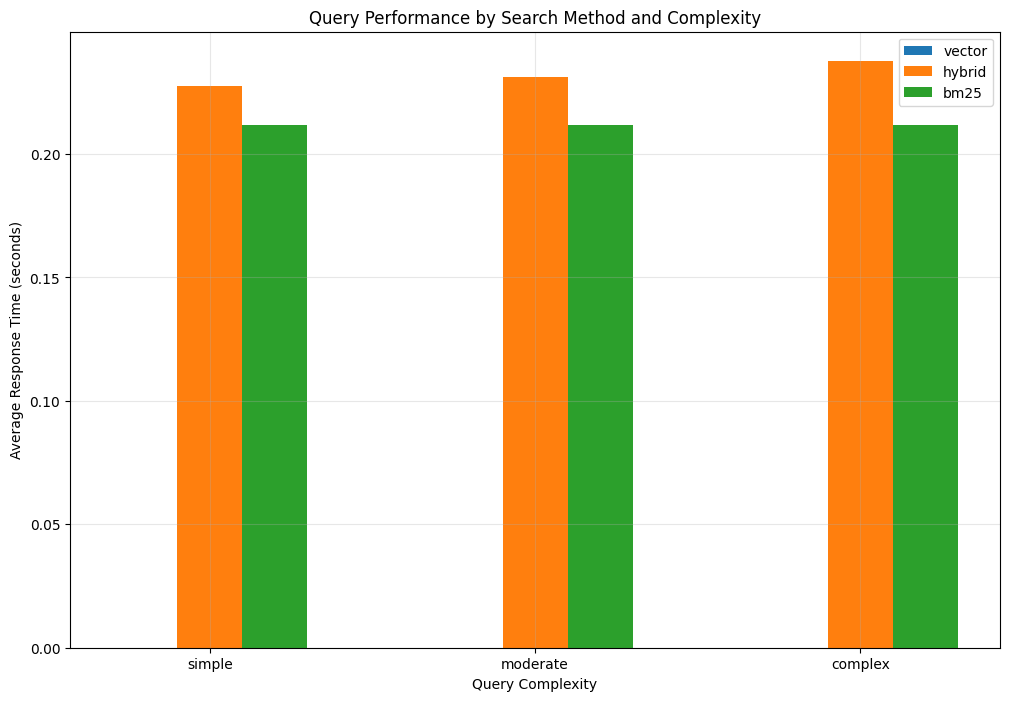

<ipython-input-8-1cc64d5112cb>:274: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods)
<ipython-input-8-1cc64d5112cb>:274: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods)
<ipython-input-8-1cc64d5112cb>:274: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods)


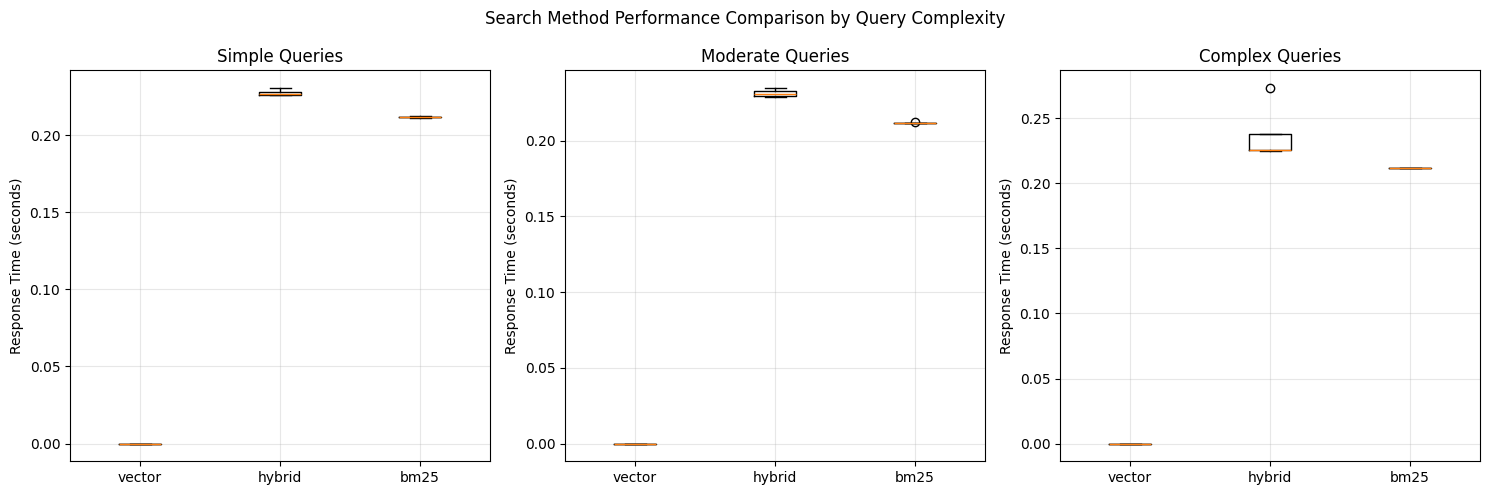


=== VECTOR INDEX ANALYSIS FOR 'PubMedArticle' ===
Vector index configuration not available

Index efficiency considerations:
  • HNSW index parameters balance search speed vs. accuracy
  • Higher 'ef' values increase recall but reduce speed
  • Higher 'maxConnections' values increase memory usage but improve accuracy
  • Optimal configuration depends on your data distribution and query patterns


In [8]:
# Code Cell 5: Analyze Query Performance and Index Efficiency
# This cell performs advanced analysis on query performance and index efficiency

import weaviate
from weaviate.connect import ConnectionParams
import pandas as pd
from tabulate import tabulate
import time
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer

# Connection parameters
weaviate_url = "http://149.165.151.58:8080"
weaviate_grpc_host = "149.165.151.58"
weaviate_grpc_port = 50051
weaviate_api_key = "ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE="
embedding_model = "pritamdeka/S-PubMedBERT-MS-MARCO"  # Using the model from your config

# Collection to analyze (change if needed)
COLLECTION_NAME = "PubMedArticle"

# Queries for different complexity levels
query_sets = {
    "simple": [
        "diabetes",
        "cancer",
        "heart disease",
        "gene therapy"
    ],
    "moderate": [
        "treatment for type 2 diabetes",
        "breast cancer immunotherapy",
        "cardiac arrhythmia diagnosis methods",
        "gene expression regulation in cancer"
    ],
    "complex": [
        "novel treatment approaches for resistant type 2 diabetes with comorbidities",
        "mechanisms of resistance to immunotherapy in triple-negative breast cancer",
        "non-invasive diagnostic techniques for cardiac arrhythmias in pediatric patients",
        "epigenetic regulation of gene expression in metastatic colorectal cancer"
    ]
}

def connect_to_weaviate():
    """Connect to Weaviate instance."""
    print(f"Connecting to Weaviate at {weaviate_url}")

    try:
        # Extract HTTP host and port from URL
        url_parts = weaviate_url.split("://")
        http_secure = url_parts[0] == "https"

        if len(url_parts) > 1:
            http_parts = url_parts[1].split(":")
            http_host = http_parts[0]
            http_port = int(http_parts[1]) if len(http_parts) > 1 else 8080
        else:
            print("Invalid Weaviate URL format")
            return None

        # Create connection params
        connection_params = ConnectionParams.from_params(
            http_host=http_host,
            http_port=http_port,
            http_secure=http_secure,
            grpc_host=weaviate_grpc_host,
            grpc_port=weaviate_grpc_port,
            grpc_secure=False
        )

        # Set up authentication
        import weaviate.classes.init as wvc_init
        auth = wvc_init.Auth.api_key(weaviate_api_key)

        # Create client
        client = weaviate.WeaviateClient(
            connection_params=connection_params,
            auth_client_secret=auth
        )

        # Connect the client explicitly
        client.connect()

        # Verify connection
        is_ready = client.is_ready()
        print(f"Weaviate is ready: {is_ready}")

        if is_ready:
            return client
        else:
            print("Failed to connect to Weaviate")
            return None

    except Exception as e:
        print(f"Error connecting to Weaviate: {str(e)}")
        return None

def load_embedding_model():
    """Load the embedding model."""
    print(f"Loading embedding model: {embedding_model}")
    try:
        model = SentenceTransformer(embedding_model)
        print("Embedding model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading embedding model: {str(e)}")
        # Fall back to a simpler model if the specific one fails
        try:
            print("Trying fallback to all-MiniLM-L6-v2 model...")
            model = SentenceTransformer("all-MiniLM-L6-v2")
            print("Fallback embedding model loaded successfully")
            return model
        except Exception as e2:
            print(f"Error loading fallback model: {str(e2)}")
            return None

def benchmark_query_performance(client, model, collection_name, query_sets):
    """Benchmark query performance across different query types and search methods."""
    if not client or not model:
        print("Client or model not available")
        return

    try:
        # Get the collection
        collection = client.collections.get(collection_name)
        print(f"\n=== QUERY PERFORMANCE BENCHMARK FOR '{collection_name}' ===")

        # Results storage
        all_results = []

        # Search methods to test
        search_methods = ['vector', 'hybrid', 'bm25']

        # Test each complexity level
        for complexity, queries in query_sets.items():
            print(f"\nTesting {complexity} queries...")

            for query in queries:
                print(f"  Query: '{query}'")

                # Encode query once for vector searches
                try:
                    encode_start = time.time()
                    query_vector = model.encode(query).tolist()
                    encode_time = time.time() - encode_start
                    print(f"  Encoding time: {encode_time:.4f} seconds")
                except Exception as e:
                    print(f"  Error encoding query: {str(e)}")
                    continue

                # Test each search method
                for method in search_methods:
                    try:
                        print(f"  Testing {method} search...")

                        # Performance metrics
                        start_time = time.time()

                        # Perform search based on method
                        if method == 'vector':
                            results = collection.query.near_vector(
                                vector=query_vector,
                                limit=5,
                                return_properties=["pmid", "title", "section"]
                            )
                        elif method == 'hybrid':
                            results = collection.query.hybrid(
                                query=query,
                                vector=query_vector,
                                alpha=0.5,  # Balance between vector and keyword search
                                limit=5,
                                return_properties=["pmid", "title", "section"]
                            )
                        elif method == 'bm25':
                            results = collection.query.bm25(
                                query=query,
                                limit=5,
                                return_properties=["pmid", "title", "section"]
                            )

                        search_time = time.time() - start_time
                        result_count = len(results.objects) if hasattr(results, 'objects') else 0

                        # Store result
                        all_results.append({
                            'Complexity': complexity,
                            'Query': query,
                            'Method': method,
                            'Encoding Time (s)': encode_time if method != 'bm25' else 0,
                            'Search Time (s)': search_time,
                            'Total Time (s)': search_time + (encode_time if method != 'bm25' else 0),
                            'Results Found': result_count
                        })

                        print(f"    Found {result_count} results in {search_time:.4f} seconds")

                    except Exception as e:
                        print(f"    Error with {method} search: {str(e)}")
                        # Store error result
                        all_results.append({
                            'Complexity': complexity,
                            'Query': query,
                            'Method': method,
                            'Encoding Time (s)': encode_time if method != 'bm25' else 0,
                            'Search Time (s)': 0,
                            'Total Time (s)': 0,
                            'Results Found': 0,
                            'Error': str(e)
                        })

        # Convert to DataFrame for analysis
        df_results = pd.DataFrame(all_results)

        # Display summary
        if not df_results.empty:
            print("\n=== PERFORMANCE SUMMARY ===")

            # Group by complexity and method
            summary = df_results.groupby(['Complexity', 'Method'])[['Search Time (s)', 'Total Time (s)', 'Results Found']].mean().reset_index()

            # Format for display
            summary['Search Time (s)'] = summary['Search Time (s)'].round(4)
            summary['Total Time (s)'] = summary['Total Time (s)'].round(4)
            summary['Results Found'] = summary['Results Found'].round(1)

            print(tabulate(summary, headers='keys', tablefmt='grid', showindex=False))

            # Create visualization
            try:
                plt.figure(figsize=(12, 8))

                # Create grouped bar chart for search times
                complexity_types = df_results['Complexity'].unique()
                method_types = df_results['Method'].unique()

                x = np.arange(len(complexity_types))
                width = 0.2
                multiplier = 0

                for method in method_types:
                    method_data = df_results[df_results['Method'] == method]
                    avg_times = [method_data[method_data['Complexity'] == c]['Total Time (s)'].mean() for c in complexity_types]

                    offset = width * multiplier
                    rects = plt.bar(x + offset, avg_times, width, label=method)
                    multiplier += 1

                plt.xlabel('Query Complexity')
                plt.ylabel('Average Response Time (seconds)')
                plt.title('Query Performance by Search Method and Complexity')
                plt.xticks(x + width, complexity_types)
                plt.legend(loc='best')
                plt.grid(True, alpha=0.3)
                plt.show()
            except Exception as e:
                print(f"Error creating visualization: {str(e)}")

            # Detailed method comparison
            try:
                # Compare methods based on query complexity
                plt.figure(figsize=(15, 5))

                for i, complexity in enumerate(['simple', 'moderate', 'complex']):
                    plt.subplot(1, 3, i+1)

                    # Filter data
                    complex_data = df_results[df_results['Complexity'] == complexity]

                    # Grouped boxplot
                    methods = complex_data['Method'].unique()
                    data = [complex_data[complex_data['Method'] == method]['Total Time (s)'] for method in methods]

                    plt.boxplot(data, labels=methods)
                    plt.title(f'{complexity.capitalize()} Queries')
                    plt.ylabel('Response Time (seconds)')
                    plt.grid(True, alpha=0.3)

                plt.suptitle('Search Method Performance Comparison by Query Complexity')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error creating comparison visualization: {str(e)}")

    except Exception as e:
        print(f"Error benchmarking performance: {str(e)}")

def analyze_index_efficiency(client, collection_name="PubMedArticle"):
    """Analyze vector index efficiency."""
    if not client:
        print("Client not available")
        return

    try:
        # Get the collection
        collection = client.collections.get(collection_name)
        print(f"\n=== VECTOR INDEX ANALYSIS FOR '{collection_name}' ===")

        # Get configuration
        vector_config = None
        if hasattr(collection, "config") and hasattr(collection.config, "vector_index_config"):
            vector_config = collection.config.vector_index_config

            print("Vector index configuration:")

            # Display key configuration parameters
            if hasattr(vector_config, "distance"):
                print(f"  Distance metric: {vector_config.distance}")

            # For HNSW index
            hnsw_config = getattr(vector_config, "hnsw", None)
            if hnsw_config:
                print("  HNSW configuration:")
                if hasattr(hnsw_config, "ef"):
                    print(f"    ef: {hnsw_config.ef}")
                if hasattr(hnsw_config, "efConstruction"):
                    print(f"    efConstruction: {hnsw_config.efConstruction}")
                if hasattr(hnsw_config, "maxConnections"):
                    print(f"    maxConnections: {hnsw_config.maxConnections}")

            # General parameters
            if hasattr(vector_config, "vectors_per_shard"):
                print(f"  Vectors per shard: {vector_config.vectors_per_shard}")
            if hasattr(vector_config, "cache_config"):
                print(f"  Cache config: {vector_config.cache_config}")
        else:
            print("Vector index configuration not available")

        # Perform a simple benchmark to test recall/speed tradeoff
        # Here we would ideally test different ef values, but that's typically
        # not configurable at query time through the client

        print("\nIndex efficiency considerations:")
        print("  • HNSW index parameters balance search speed vs. accuracy")
        print("  • Higher 'ef' values increase recall but reduce speed")
        print("  • Higher 'maxConnections' values increase memory usage but improve accuracy")
        print("  • Optimal configuration depends on your data distribution and query patterns")

    except Exception as e:
        print(f"Error analyzing index efficiency: {str(e)}")

# Connect to Weaviate
client = connect_to_weaviate()

# Load the embedding model
model = load_embedding_model()

if client and model:
    # Benchmark query performance
    benchmark_query_performance(client, model, COLLECTION_NAME, query_sets)

    # Analyze index efficiency
    analyze_index_efficiency(client, COLLECTION_NAME)
else:
    print("Unable to perform analysis due to connection or model loading issues")

Connecting to Weaviate at http://149.165.151.58:8080
Weaviate is ready: True

=== DATABASE STORAGE ANALYSIS ===
Found 2 collections
Error listing collections: 'str' object has no attribute 'name'

=== CHUNK ANALYSIS FOR COLLECTION 'PubMedArticle' ===
Analyzing 100 sample objects for chunk analysis
Chunk length statistics (characters):
  Average length: 2027.06
  Maximum length: 4040
  Minimum length: 173
  Configured max chunk size: 500


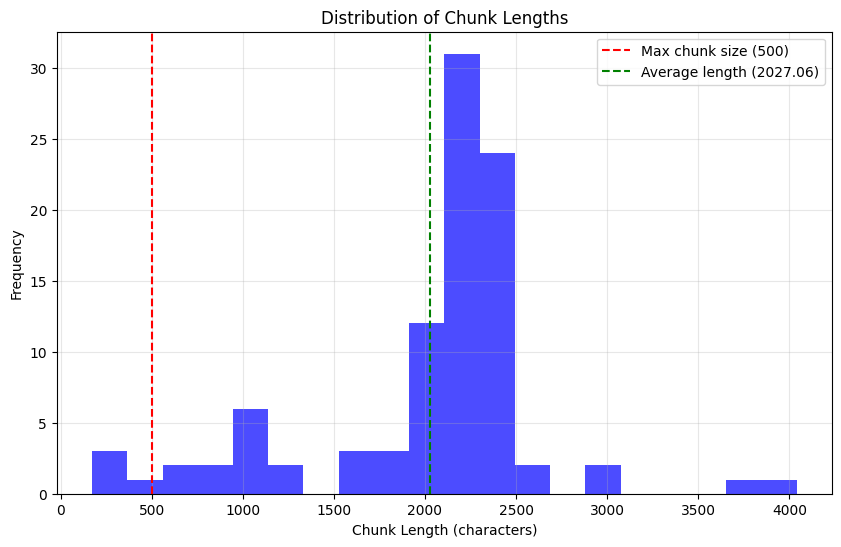


Chunk length distribution:
+----------------+---------+--------------+
| length_group   |   count |   percentage |
+================+=========+==============+
| 0-100          |       0 |         0    |
+----------------+---------+--------------+
| 101-200        |       3 |         3.16 |
+----------------+---------+--------------+
| 201-300        |       0 |         0    |
+----------------+---------+--------------+
| 301-400        |       0 |         0    |
+----------------+---------+--------------+
| 401-500        |       1 |         1.05 |
+----------------+---------+--------------+
| 501-600        |       1 |         1.05 |
+----------------+---------+--------------+
| 601-700        |       1 |         1.05 |
+----------------+---------+--------------+
| 701-800        |       0 |         0    |
+----------------+---------+--------------+
| 801-900        |       1 |         1.05 |
+----------------+---------+--------------+
| 901-1000       |       1 |         1.05 |
+---

<ipython-input-9-5d68b387edae>:292: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_table = hist_data.groupby('length_group').size().reset_index(name='count')


In [9]:
# Code Cell 4: Analyze Database Storage and Chunk Distribution
# This cell analyzes the storage patterns and chunk distribution in your Weaviate database

import weaviate
from weaviate.connect import ConnectionParams
import pandas as pd
from tabulate import tabulate
import json
import matplotlib.pyplot as plt
import numpy as np

# Connection parameters
weaviate_url = "http://149.165.151.58:8080"
weaviate_grpc_host = "149.165.151.58"
weaviate_grpc_port = 50051
weaviate_api_key = "ZEwUMscMSntgpraNQGU0EcBGXX5JccIgoJ0yk+k1sGE="
max_chunk_size = 500  # From your config

def connect_to_weaviate():
    """Connect to Weaviate instance."""
    print(f"Connecting to Weaviate at {weaviate_url}")

    try:
        # Extract HTTP host and port from URL
        url_parts = weaviate_url.split("://")
        http_secure = url_parts[0] == "https"

        if len(url_parts) > 1:
            http_parts = url_parts[1].split(":")
            http_host = http_parts[0]
            http_port = int(http_parts[1]) if len(http_parts) > 1 else 8080
        else:
            print("Invalid Weaviate URL format")
            return None

        # Create connection params
        connection_params = ConnectionParams.from_params(
            http_host=http_host,
            http_port=http_port,
            http_secure=http_secure,
            grpc_host=weaviate_grpc_host,
            grpc_port=weaviate_grpc_port,
            grpc_secure=False
        )

        # Set up authentication
        import weaviate.classes.init as wvc_init
        auth = wvc_init.Auth.api_key(weaviate_api_key)

        # Create client
        client = weaviate.WeaviateClient(
            connection_params=connection_params,
            auth_client_secret=auth
        )

        # Connect the client explicitly
        client.connect()

        # Verify connection
        is_ready = client.is_ready()
        print(f"Weaviate is ready: {is_ready}")

        if is_ready:
            return client
        else:
            print("Failed to connect to Weaviate")
            return None

    except Exception as e:
        print(f"Error connecting to Weaviate: {str(e)}")
        return None

def format_size(size_bytes):
    """Format bytes to human-readable format."""
    if size_bytes < 1024:
        return f"{size_bytes} bytes"
    elif size_bytes < 1024**2:
        return f"{size_bytes/1024:.2f} KB"
    elif size_bytes < 1024**3:
        return f"{size_bytes/1024**2:.2f} MB"
    elif size_bytes < 1024**4:
        return f"{size_bytes/1024**3:.2f} GB"
    else:
        return f"{size_bytes/1024**4:.2f} TB"

def analyze_storage(client):
    """Analyze storage across all collections."""
    if not client:
        print("Client not available")
        return

    print("\n=== DATABASE STORAGE ANALYSIS ===")

    # Get all collections
    try:
        collections = client.collections.list_all()
        print(f"Found {len(collections)} collections")

        # Create storage summary
        storage_summary = []

        # Analyze each collection
        for collection in collections:
            try:
                print(f"\nAnalyzing collection: {collection.name}")

                # Get object count
                count_result = collection.aggregate.over_all()
                total_count = count_result.total_count
                print(f"Total objects: {total_count:,}")

                # Get vector dimension from a sample object
                vector_dimension = 0
                try:
                    vector_obj = collection.query.fetch_objects(
                        limit=1,
                        include_vector=True
                    )

                    if vector_obj.objects and hasattr(vector_obj.objects[0], "vector"):
                        vector_dimension = len(vector_obj.objects[0].vector)
                        print(f"Vector dimension: {vector_dimension}")
                except Exception as e:
                    print(f"Error getting vector dimension: {str(e)}")

                # Calculate approximate storage
                # Vector storage (4 bytes per float)
                vector_storage = vector_dimension * 4 * total_count  # in bytes

                # Estimate property storage (approximate)
                avg_property_size = 0
                try:
                    # Get a few sample objects to estimate property size
                    sample_objs = collection.query.fetch_objects(
                        limit=10,
                        include_vector=False
                    )

                    total_size = 0
                    for obj in sample_objs.objects:
                        # Estimate size by JSON serialization
                        size = len(json.dumps(obj.properties).encode('utf-8'))
                        total_size += size

                    if sample_objs.objects:
                        avg_property_size = total_size / len(sample_objs.objects)
                except Exception as e:
                    print(f"Error estimating property size: {str(e)}")
                    avg_property_size = 1000  # Fallback estimate

                property_storage = avg_property_size * total_count
                total_storage = vector_storage + property_storage

                # Add to summary
                storage_summary.append({
                    "Collection": collection.name,
                    "Objects": total_count,
                    "Vector Dim": vector_dimension,
                    "Vector Storage": format_size(vector_storage),
                    "Property Storage": format_size(property_storage),
                    "Total Storage": format_size(total_storage),
                    "Avg. Object Size": format_size(total_storage / total_count if total_count > 0 else 0)
                })

                # Print storage details
                print(f"Vector storage: {format_size(vector_storage)}")
                print(f"Property storage: {format_size(property_storage)}")
                print(f"Total estimated storage: {format_size(total_storage)}")
                print(f"Average object size: {format_size(total_storage / total_count if total_count > 0 else 0)}")

            except Exception as e:
                print(f"Error analyzing collection {collection.name}: {str(e)}")

        # Display storage summary
        if storage_summary:
            print("\n=== STORAGE SUMMARY ===")
            df_storage = pd.DataFrame(storage_summary)
            print(tabulate(df_storage, headers='keys', tablefmt='grid', showindex=False))

            # Try to create a storage chart
            try:
                plt.figure(figsize=(10, 6))
                collections = df_storage['Collection'].tolist()

                # Convert storage strings back to bytes for plotting
                def parse_size(size_str):
                    if 'bytes' in size_str:
                        return float(size_str.split(' ')[0])
                    elif 'KB' in size_str:
                        return float(size_str.split(' ')[0]) * 1024
                    elif 'MB' in size_str:
                        return float(size_str.split(' ')[0]) * 1024**2
                    elif 'GB' in size_str:
                        return float(size_str.split(' ')[0]) * 1024**3
                    elif 'TB' in size_str:
                        return float(size_str.split(' ')[0]) * 1024**4
                    return 0

                # Parse storage values
                vector_storage = [parse_size(x) for x in df_storage['Vector Storage'].tolist()]
                property_storage = [parse_size(x) for x in df_storage['Property Storage'].tolist()]

                # Create stacked bar chart
                bar_width = 0.5
                x = np.arange(len(collections))

                plt.bar(x, vector_storage, bar_width, label='Vector Storage')
                plt.bar(x, property_storage, bar_width, bottom=vector_storage, label='Property Storage')

                plt.xlabel('Collections')
                plt.ylabel('Storage (bytes)')
                plt.title('Storage Usage by Collection')
                plt.xticks(x, collections, rotation=45)
                plt.legend()
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error creating storage chart: {str(e)}")

    except Exception as e:
        print(f"Error listing collections: {str(e)}")

def analyze_chunks(client, collection_name="PubMedArticle"):
    """Analyze chunk distribution in a collection."""
    if not client:
        print("Client not available")
        return

    try:
        # Get the collection
        collection = client.collections.get(collection_name)
        print(f"\n=== CHUNK ANALYSIS FOR COLLECTION '{collection_name}' ===")

        # Get a sample of objects to analyze text length distribution
        try:
            # Use a larger sample for better statistics
            sample_objs = collection.query.fetch_objects(
                limit=100,
                include_vector=False
            )

            if sample_objs.objects:
                print(f"Analyzing {len(sample_objs.objects)} sample objects for chunk analysis")

                # Analyze text lengths
                text_lengths = []
                for obj in sample_objs.objects:
                    # Get text field (adjust field name if needed)
                    text = obj.properties.get('text', '')
                    if text:
                        text_lengths.append(len(text))

                if text_lengths:
                    # Calculate statistics
                    avg_length = sum(text_lengths) / len(text_lengths)
                    max_length = max(text_lengths)
                    min_length = min(text_lengths)

                    print(f"Chunk length statistics (characters):")
                    print(f"  Average length: {avg_length:.2f}")
                    print(f"  Maximum length: {max_length}")
                    print(f"  Minimum length: {min_length}")
                    print(f"  Configured max chunk size: {max_chunk_size}")

                    # Check if any chunks exceed the configured max size
                    oversize_chunks = sum(1 for length in text_lengths if length > max_chunk_size)
                    if oversize_chunks > 0:
                        print(f"Warning: {oversize_chunks} chunks ({oversize_chunks/len(text_lengths)*100:.2f}%) exceed the configured maximum size")

                    # Calculate distribution
                    hist_data = pd.DataFrame({'text_length': text_lengths})

                    # Plot histogram of chunk sizes
                    try:
                        plt.figure(figsize=(10, 6))
                        plt.hist(text_lengths, bins=20, alpha=0.7, color='blue')
                        plt.axvline(x=max_chunk_size, color='r', linestyle='--', label=f'Max chunk size ({max_chunk_size})')
                        plt.axvline(x=avg_length, color='g', linestyle='--', label=f'Average length ({avg_length:.2f})')
                        plt.xlabel('Chunk Length (characters)')
                        plt.ylabel('Frequency')
                        plt.title('Distribution of Chunk Lengths')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        plt.show()
                    except Exception as e:
                        print(f"Error creating histogram: {str(e)}")

                    # Show distribution table
                    bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]
                    labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '1000+']
                    hist_data['length_group'] = pd.cut(hist_data['text_length'], bins=bins, labels=labels)
                    dist_table = hist_data.groupby('length_group').size().reset_index(name='count')
                    dist_table['percentage'] = dist_table['count'] / len(text_lengths) * 100

                    print("\nChunk length distribution:")
                    dist_table['percentage'] = dist_table['percentage'].round(2)
                    print(tabulate(dist_table, headers='keys', tablefmt='grid', showindex=False))
                else:
                    print("No text fields found in sample objects")
            else:
                print("No sample objects returned")

        except Exception as e:
            print(f"Error analyzing text chunks: {str(e)}")

        # Analyze chunk distribution per document (using pmid)
        try:
            if 'pmid' in [p.name for p in collection.properties]:
                print("\nAnalyzing chunks per document...")

                # Group by PMID with aggregate
                group_results = collection.aggregate.group_by(
                    property_name='pmid',
                    limit=100  # Get top 100 documents by count
                )

                if group_results and hasattr(group_results, "groups"):
                    # Create dataframe from results
                    doc_chunks = []
                    for group in group_results.groups:
                        doc_chunks.append({
                            'PMID': group.value,
                            'Chunk Count': group.count
                        })

                    if doc_chunks:
                        # Convert to dataframe
                        df_chunks = pd.DataFrame(doc_chunks)

                        # Calculate statistics
                        avg_chunks = df_chunks['Chunk Count'].mean()
                        max_chunks = df_chunks['Chunk Count'].max()
                        min_chunks = df_chunks['Chunk Count'].min()

                        print(f"Chunks per document statistics:")
                        print(f"  Average chunks: {avg_chunks:.2f}")
                        print(f"  Maximum chunks: {max_chunks}")
                        print(f"  Minimum chunks: {min_chunks}")

                        # Plot histogram
                        try:
                            plt.figure(figsize=(10, 6))
                            plt.hist(df_chunks['Chunk Count'], bins=20, alpha=0.7, color='green')
                            plt.axvline(x=avg_chunks, color='r', linestyle='--', label=f'Average ({avg_chunks:.2f})')
                            plt.xlabel('Number of Chunks')
                            plt.ylabel('Frequency')
                            plt.title('Distribution of Chunks per Document')
                            plt.legend()
                            plt.grid(True, alpha=0.3)
                            plt.show()
                        except Exception as e:
                            print(f"Error creating histogram: {str(e)}")

                        # Show top documents by chunk count
                        print("\nTop 10 documents by chunk count:")
                        top_docs = df_chunks.sort_values('Chunk Count', ascending=False).head(10)
                        print(tabulate(top_docs, headers='keys', tablefmt='grid', showindex=False))
                    else:
                        print("No document chunk data found")
                else:
                    print("No grouping results returned")
            else:
                print("No 'pmid' field found for document analysis")

        except Exception as e:
            print(f"Error analyzing document chunks: {str(e)}")

    except Exception as e:
        print(f"Error analyzing collection {collection_name}: {str(e)}")

# Connect to Weaviate
client = connect_to_weaviate()

if client:
    # Analyze overall storage
    analyze_storage(client)

    # Analyze chunks in the PubMedArticle collection
    # Replace with your actual collection name if different
    analyze_chunks(client, "PubMedArticle")
else:
    print("Failed to connect to Weaviate. Check your connection parameters and API key.")